<a href="https://colab.research.google.com/github/chalika-vanyaa/Demand_Forecasting_Predictive_Analytics/blob/main/Demand_Forecasting_Retail_Predictive_Analytics_Project_Chalika_Vanya_Resya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Libraries**

> Pada bagian ini dilakukan `import` seluruh *library* yang digunakan pada pembuatan projek, termasuk untuk **`data loading`**, **`exploratory data analysis`**, **`data preprocessing`**, serta **`modeling dan evaluation`**.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from google.colab import drive

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

## **About Dataset**

Fitur kunci pada dataset:
- `Date`: Daily records from [start_date] to [end_date].
- `Store ID` & `Product ID`: Unique identifiers for stores and products.
- `Category`: Product categories like Electronics, Clothing, Groceries, etc.
- `Region`: Geographic region of the store.
- `Inventory Level`: Stock available at the beginning of the day.
- `Units Sold`: Units sold during the day (**target variable**).
- `Units Ordered`: Stock reordered.
- `Demand Forecast`: Predicted demand based on past trends.
- `Price`, `Discount`: Pricing Data
- `Weather Condition`: Daily weather impacting sales.
- `Holiday/Promotion`: Indicators for holidays or promotions (0 for False, 1 for True).
- `Competitor Pricing`: Price sold by the competitor.
- `Seasonality`: Yearly season (Autumn, Spring, Winter, & Summer)

Sumber Dataset: [Kaggle Retail Demand Forecast Dataset](https://www.kaggle.com/datasets/anirudhchauhan/retail-store-inventory-forecasting-dataset/data)

## **Data Loading**

> Pada bagian ini dilakukan tahapan ***data loading***, dengan mengambil file *dataset* yang sudah tersimpan pada folder di google drive.

In [ ]:
# mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data loading
fileName = '/content/drive/MyDrive/Online Courses/Dicoding/ML Engineer Track/Level Mahir/Projects/Predictive Analytics Project/'
os.chdir(fileName)

df = pd.read_csv('retail_store_inventory.csv')
df.head()

Date Store ID Product ID     Category Region  Inventory Level  \
0  2022-01-01     S001      P0001    Groceries  North              231   
1  2022-01-01     S001      P0002         Toys  South              204   
2  2022-01-01     S001      P0003         Toys   West              102   
3  2022-01-01     S001      P0004         Toys  North              469   
4  2022-01-01     S001      P0005  Electronics   East              166   

   Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
0         127             55           135.47  33.50        20   
1         150             66           144.04  63.01        20   
2          65             51            74.02  27.99        10   
3          61            164            62.18  32.72        10   
4          14            135             9.26  73.64         0   

  Weather Condition  Holiday/Promotion  Competitor Pricing Seasonality  
0             Rainy                  0               29.69      Autumn  
1             Sunny                  0               66.16      Autumn  
2             Sunny                  1               31.32      Summer  
3            Cloudy                  1               34.74      Autumn  
4             Sunny                  0               68.95      Summer

> Kode di atas melakukan *mounting* pada google drive untuk mengambil file *dataset* yang disimpan pada folder dengan url yang tertera. File *dataset* diberi nama `retail_store_inventory.csv` yang merupakan *dataset* mengenai data sintesis realistis mengenai *demand* produk pada toko ritel. Data ini diambil dari Kaggle dan dapat diakses melalui link berikut: [Kaggle Retail Demand Forecast Dataset](https://www.kaggle.com/datasets/anirudhchauhan/retail-store-inventory-forecasting-dataset/data).

## **Data Understanding**

> Pada bagian ini dikulik mengenai data, seperti jumlah baris dan kolom, tipe data kolom, statistik deskriptif, *missing values*, hingga analisis dan perbaikan singkat pada kolom sebelum masuk ke tahapan *exploratory data analysis*.

In [ ]:
# basic information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

> Dataset terdiri dari 73.100 data dengan 15 kolom dengan tipe berbeda, termasuk numerik (`Inventory Level`, `Units Sold`, `Units Ordered`, `Demand Forecast`, `Price`, `Discount`, `Holiday/Promotion`, dan `Competitor Pricing`) serta kategorikal (`Date`, `Store ID`, `Product ID`, `Category`, `Region`, `Weather Condition`, dan `Seasonality`). Sekilas terlihat bahwa tidak terdapat nilai null pada masing-masing kolom.

In [ ]:
# descriptive statistics
df.describe()

Inventory Level    Units Sold  Units Ordered  Demand Forecast  \
count     73100.000000  73100.000000   73100.000000     73100.000000   
mean        274.469877    136.464870     110.004473       141.494720   
std         129.949514    108.919406      52.277448       109.254076   
min          50.000000      0.000000      20.000000        -9.990000   
25%         162.000000     49.000000      65.000000        53.670000   
50%         273.000000    107.000000     110.000000       113.015000   
75%         387.000000    203.000000     155.000000       208.052500   
max         500.000000    499.000000     200.000000       518.550000   

              Price      Discount  Holiday/Promotion  Competitor Pricing  
count  73100.000000  73100.000000       73100.000000        73100.000000  
mean      55.135108     10.009508           0.497305           55.146077  
std       26.021945      7.083746           0.499996           26.191408  
min       10.000000      0.000000           0.000000            5.030000  
25%       32.650000      5.000000           0.000000           32.680000  
50%       55.050000     10.000000           0.000000           55.010000  
75%       77.860000     15.000000           1.000000           77.820000  
max      100.000000     20.000000           1.000000          104.940000

> Tabel di atas menampilkan data statistik deskriptif setiap kolom numerik pada dataset, yaitu:
- `count`: jumlah data pada kolom
- `mean`: rata-rata keseluruhan data pada kolom
- `std`: standard deviation/simpangan baku data pada kolom
- `min`: nilai terkecil pada kolom
- `25%`: kuartil bawah (Q1) pada kolom
- `50%`: median/kuartil tengah (Q2) pada kolom
- `75%`: kuartil atas (Q3) pada kolom
- `max`: nilai terbesar pada kolom

In [ ]:
# descriptive statistics of categorical columns
df.describe(include='object')

Date Store ID Product ID   Category Region Weather Condition  \
count        73100    73100      73100      73100  73100             73100   
unique         731        5         20          5      4                 4   
top     2024-01-01     S001      P0001  Furniture   East             Sunny   
freq           100    14620       3655      14699  18349             18290   

       Seasonality  
count        73100  
unique           4  
top         Spring  
freq         18317

> Tabel di atas menampilkan data statistik deskriptif setiap kolom kategorikal pada *dataset*, yaitu:
- `count`: jumlah data pada kolom
- `unique`: total nilai unik pada kolom
- `top`: nilai modus pada kolom
- `freq`: jumlah data modus pada kolom

In [ ]:
# rename columns by replacing space with '_' and convert to lowercase
for col in df.columns.tolist():
  renamed_col = col.lower().replace(' ', '_')
  df = df.rename(columns={col: renamed_col})

# recheck dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                73100 non-null  object 
 1   store_id            73100 non-null  object 
 2   product_id          73100 non-null  object 
 3   category            73100 non-null  object 
 4   region              73100 non-null  object 
 5   inventory_level     73100 non-null  int64  
 6   units_sold          73100 non-null  int64  
 7   units_ordered       73100 non-null  int64  
 8   demand_forecast     73100 non-null  float64
 9   price               73100 non-null  float64
 10  discount            73100 non-null  int64  
 11  weather_condition   73100 non-null  object 
 12  holiday/promotion   73100 non-null  int64  
 13  competitor_pricing  73100 non-null  float64
 14  seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

> Pada *dataset* asli, setiap kolom ditulis dengan huruf kapital di awal dan mengandung spasi. Untuk kemudahan pemanggilan kolom, penamaan kolom diubah menjadi *lowercase* dan mengganti spasi dengan *underscore* (_).

In [ ]:
# convert column date to datetime
df['date'] = pd.to_datetime(df['date'])
df['date']

0       2022-01-01
1       2022-01-01
2       2022-01-01
3       2022-01-01
4       2022-01-01
           ...    
73095   2024-01-01
73096   2024-01-01
73097   2024-01-01
73098   2024-01-01
73099   2024-01-01
Name: date, Length: 73100, dtype: datetime64[ns]

> Kolom `date` pada *dataset* masih dianggap sebagai *object*. Agar lebih informatif dan dapat diekstraksi data lainnya (seperti hari, bulan, tahun), kolom `date` diubah menjadi tipe data `datetime`.

In [ ]:
# print the first and last recorded date
print('Earliest recorded date:', df['date'].min())
print('Latest recorded date:', df['date'].max())

Earliest recorded date: 2022-01-01 00:00:00
Latest recorded date: 2024-01-01 00:00:00


> Data memiliki rentang dua tahun, dimulai dari tanggal `2022-01-01` hingga `2024-01-01`. Informasi ini membantu dalam proses pemisahan data nanti (yang akan dipisah berdasarkan urutan tanggal).


In [ ]:
# check missing values
df.isnull().sum()

date                  0
store_id              0
product_id            0
category              0
region                0
inventory_level       0
units_sold            0
units_ordered         0
demand_forecast       0
price                 0
discount              0
weather_condition     0
holiday/promotion     0
competitor_pricing    0
seasonality           0
dtype: int64

> Setelah diperiksa menggunakan *syntax* `df.isnull().sum()`, terlihat tidak terdapat kolom yang memiliki *missing values*.

In [ ]:
# check the category of each product
pd.set_option('display.max_colwidth', None)
df.groupby('category')['product_id'].apply(lambda x: sorted(x.unique())).reset_index()

category  \
0     Clothing   
1  Electronics   
2    Furniture   
3    Groceries   
4         Toys   

                                                                                                                                     product_id  
0  [P0001, P0002, P0003, P0004, P0005, P0006, P0007, P0008, P0009, P0010, P0011, P0012, P0013, P0014, P0015, P0016, P0017, P0018, P0019, P0020]  
1  [P0001, P0002, P0003, P0004, P0005, P0006, P0007, P0008, P0009, P0010, P0011, P0012, P0013, P0014, P0015, P0016, P0017, P0018, P0019, P0020]  
2  [P0001, P0002, P0003, P0004, P0005, P0006, P0007, P0008, P0009, P0010, P0011, P0012, P0013, P0014, P0015, P0016, P0017, P0018, P0019, P0020]  
3  [P0001, P0002, P0003, P0004, P0005, P0006, P0007, P0008, P0009, P0010, P0011, P0012, P0013, P0014, P0015, P0016, P0017, P0018, P0019, P0020]  
4  [P0001, P0002, P0003, P0004, P0005, P0006, P0007, P0008, P0009, P0010, P0011, P0012, P0013, P0014, P0015, P0016, P0017, P0018, P0019, P0020]

> Kode di atas dilakukan untuk melihat bagaimana pengelompokkan produk berdasarkan `product_id` dalam `category`. Ternyata, semua `product_id` termasuk ke dalam semua `category`. Hal ini bisa mengindikasikan bahwa kolom `product_id` tidak merepresentasikan produk yang unik, tetapi lebih sebagai kode acak yang tidak spesifik menggambarkan satu produk tertentu.


## **Exploratory Data Analysis**

> Bagian ini menampilkan proses eksplorasi data secara visual, baik secara univariat (satu variabel) maupun multivariat (lebih dari satu variabel), untuk memahami karakteristik data secara lebih mendalam.

### **Univariate Analysis**

> Bagian ini bertujuan untuk memahami karakteristik setiap fitur secara individual. Visualisasi yang digunakan antara lain:
- **Histogram**: untuk melihat distribusi kolom numerik
- **Boxplot**: untuk mendeteksi keberadaan *outliers*
- **Bar plot (countplot)**: untuk melihat distribusi fitur kategorikal
- **Line plot**: untuk melihat pola atau tren waktu
- **Time series decomposition**: untuk memecah data deret waktu menjadi komponen-komponen utama

In [ ]:
num_cols = df.select_dtypes('number').columns # numerical columns
cat_cols = df.drop(columns=['date', 'store_id', 'product_id']).select_dtypes('object').columns # categorical columns except date and ids

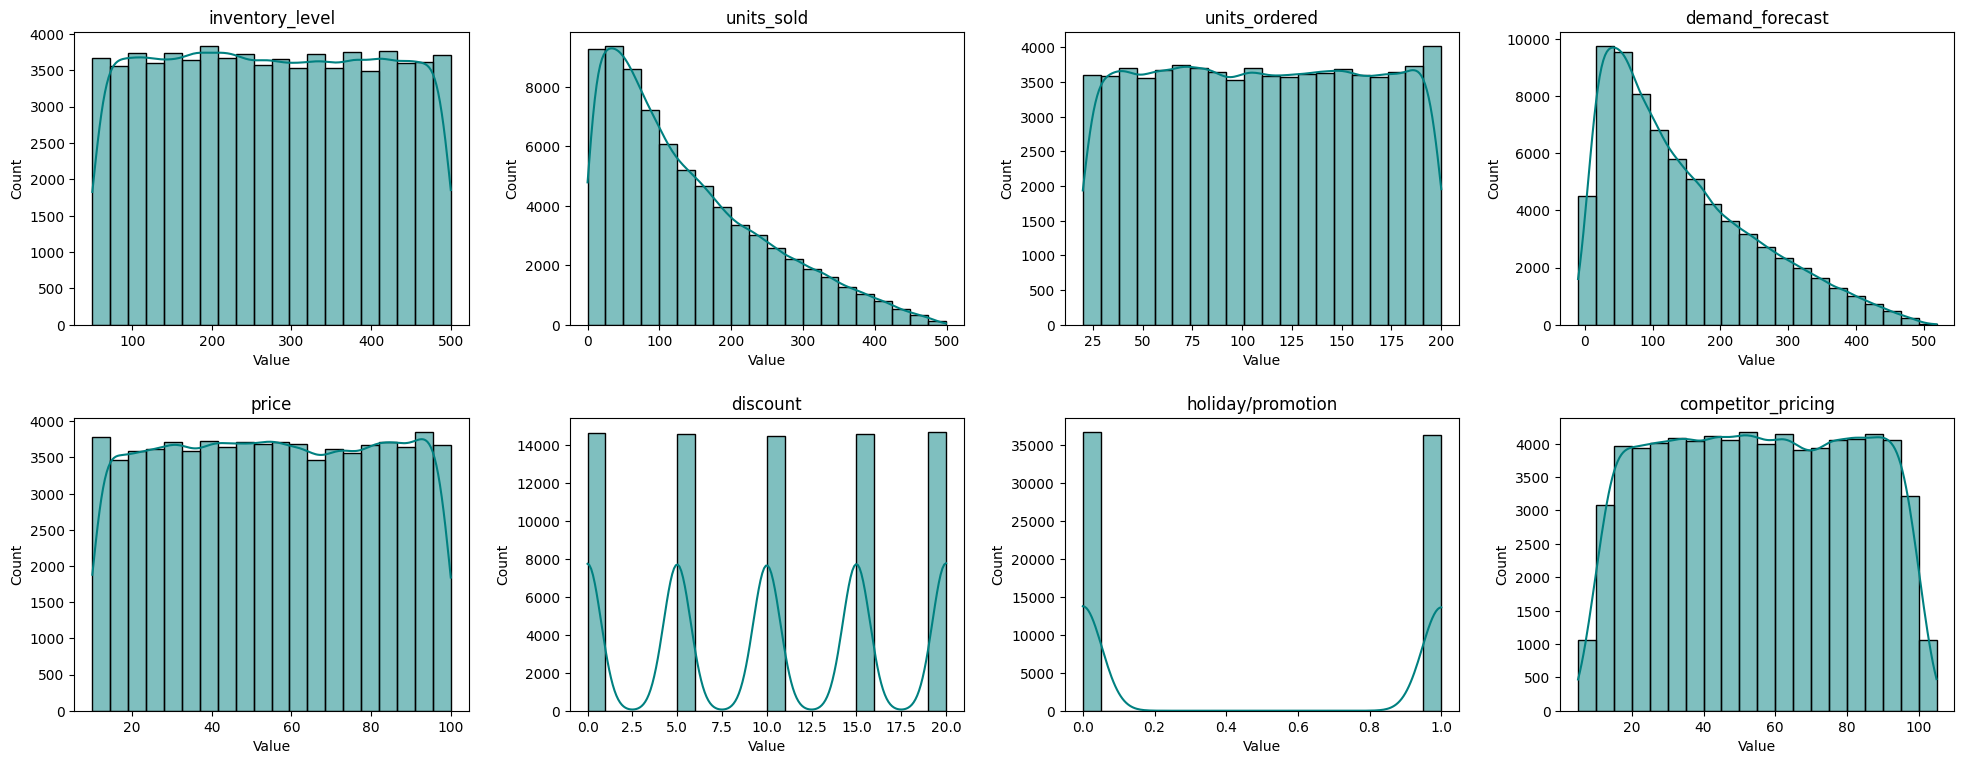

In [ ]:
# numerical columns distribution plot: histogram
def plot_histogram(df, col_list):
  n_cols = 4
  n_rows = int(np.ceil(len(col_list) / n_cols))

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))

  # flatten axes for easier iteration
  axes = axes.flatten()

  # histogram plotting
  for i, feature in enumerate(col_list):
    sns.histplot(x=df[feature], ax=axes[i], kde=True, bins=20, color='teal')
    axes[i].set_title(feature)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')

  # remove unused subplots if exists
  for j in range(len(col_list), len(axes)):
    fig.delaxes(axes[j]) # remove empty axes

  plt.tight_layout(pad=2.0)
  plt.show()

# function call
plot_histogram(df, num_cols)

> Visualisasi histogram digunakan untuk melihat distribusi dari kolom-kolom numerik, yaitu `inventory_level`, `units_sold`, `units_ordered`, `demand_forecast`, `price`, `discount`, `holiday/promotion` (biner), dan `competitor_pricing`. Sebagian besar kolom memiliki distribusi yang **cukup seragam** (*uniform*), kecuali `units_sold` dan `demand_forecast` yang menunjukkan kemencengan ke kanan (***right-skewed***). Hal ini mengindikasikan keberadaan nilai-nilai ekstrem yang sangat besar dan potensi keberadaan *outliers*. Informasi ini penting dalam menentukan pendekatan pada tahap *data preprocessing*.

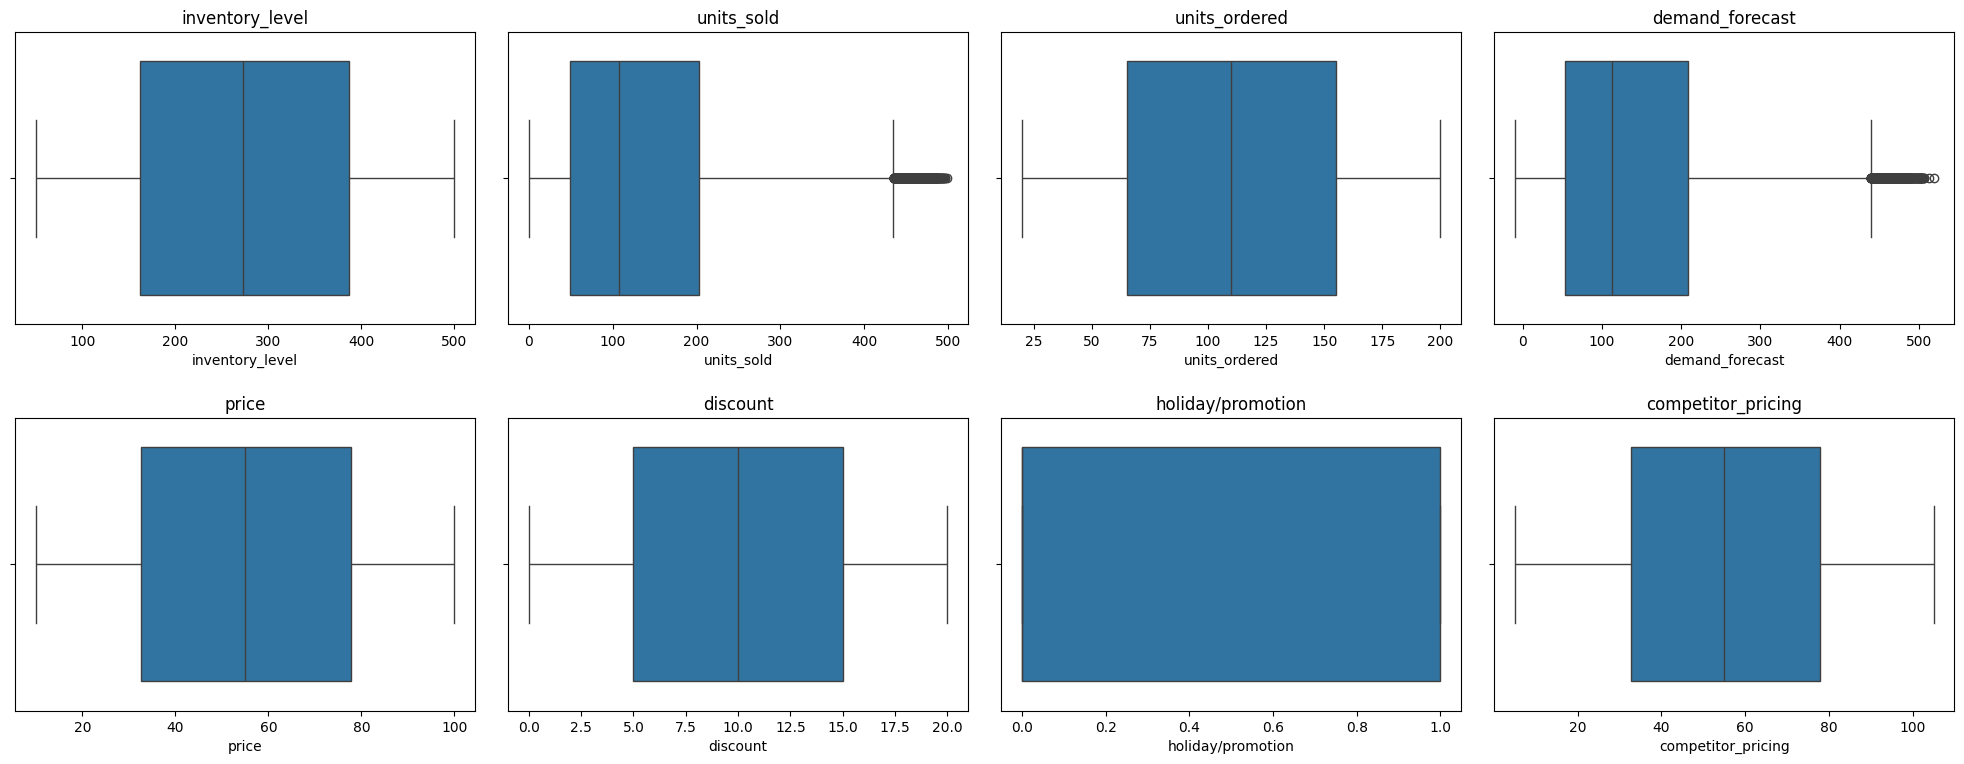

In [ ]:
# plot outliers using boxplot
def plot_outliers(df, col_list):
  n_cols = 4
  n_rows = int(np.ceil(len(col_list) / n_cols))

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))

  # flatten axes for easier iteration
  axes = axes.flatten()

  # outlier plotting using boxplot
  for i, feature in enumerate(col_list):
    sns.boxplot(x=df[feature], ax=axes[i])
    axes[i].set_title(feature)

  # remove unused subplots if exists
  for j in range(len(col_list), len(axes)):
    fig.delaxes(axes[j]) # remove empty axes

  plt.tight_layout(pad=2.0)
  plt.show()

# function call
plot_outliers(df, num_cols)

> Visualisasi boxplot menunjukkan bahwa *outliers* hanya ditemukan pada kolom `units_sold` dan `demand_forecast`, dengan posisi di atas *upper boundary*.
Temuan ini mendukung hasil dari visualisasi histogram dan menunjukkan bahwa sebagian besar nilai ekstrem berasal dari dua kolom tersebut. Analisis ini membantu dalam menentukan pendekatan penanganan *outliers*, seperti pemangkasan (*trimming*) atau transformasi data.

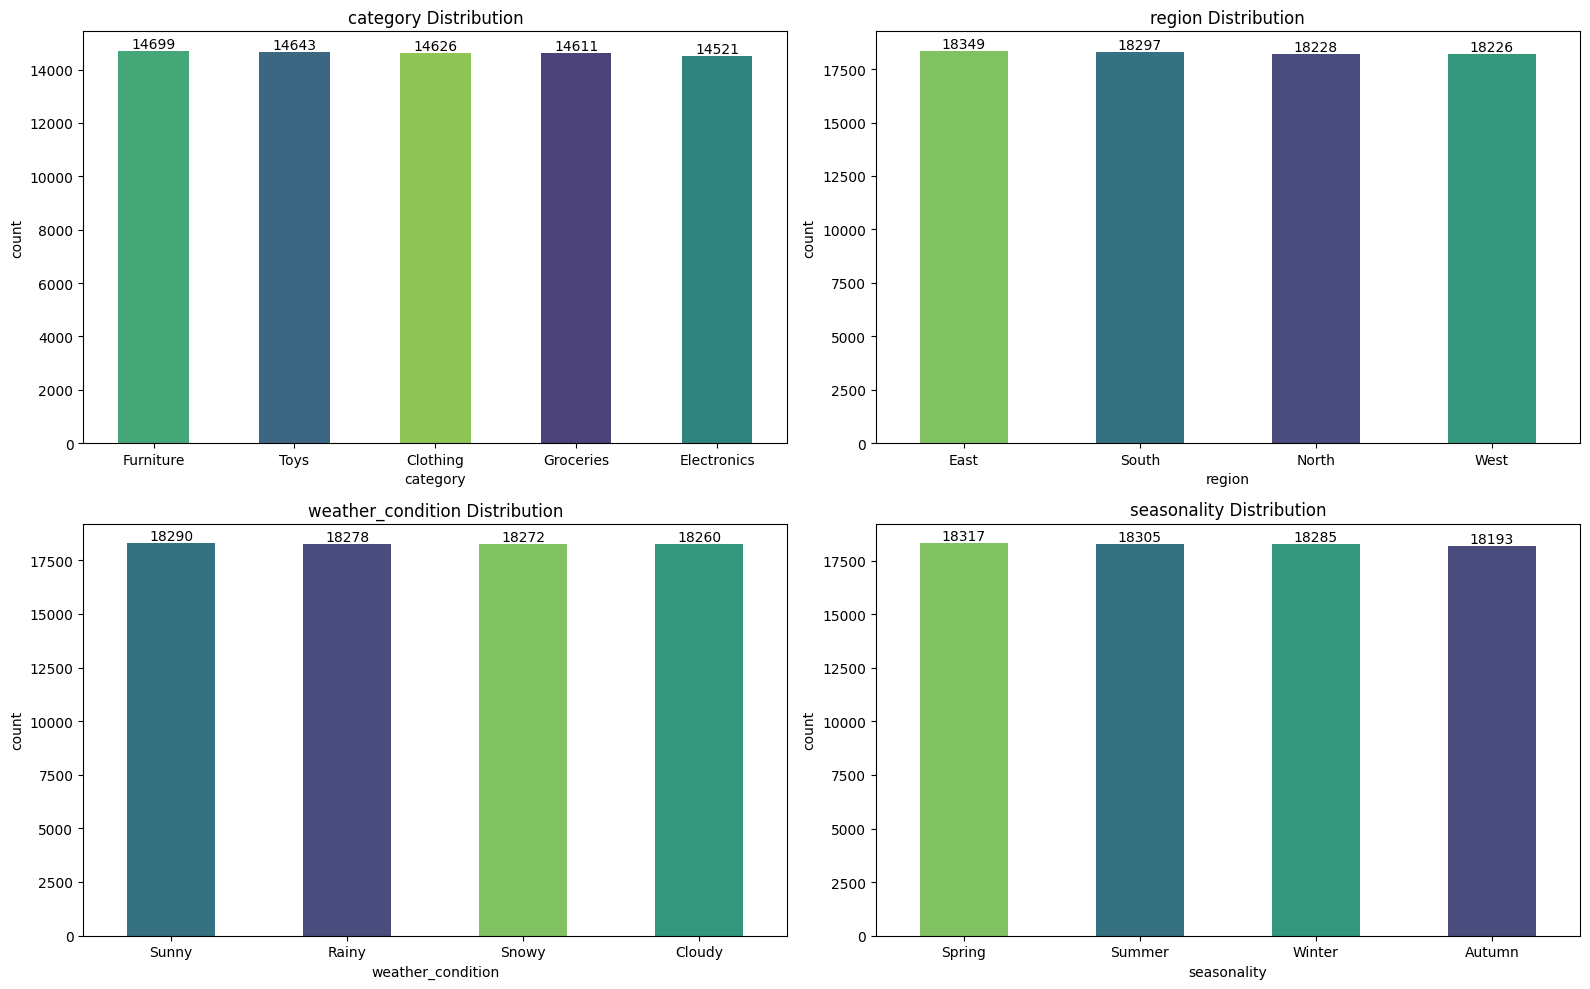

In [ ]:
# categorical data distribution: countplot
def plot_cat_dist(df, col_list):
  n_cols = 2
  n_rows = int(np.ceil(len(col_list) / n_cols))

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))

  # flatten axes for easier iteration
  axes = axes.flatten()

  for i, feat in enumerate(col_list):
    # sort values by count
    counts = df[feat].value_counts().sort_values(ascending=False)
    sorted_data = counts.index

    # countplot
    ax = sns.countplot(x=feat, data=df, ax=axes[i], order = sorted_data, hue=feat, palette='viridis', width=0.5)
    axes[i].set_title(f'{feat} Distribution')

    # add labels to each bar
    for p in ax.patches:
      ax.text(p.get_x() + p.get_width() / 2,
              p.get_height() + 0.01,
              f'{int(p.get_height())}',
              ha='center', va='bottom', fontsize=10)

  # remove unused subplots if exists
  for j in range(len(col_list), len(axes)):
    fig.delaxes(axes[j]) # remove empty axes

  plt.tight_layout()
  plt.show()

# function call
plot_cat_dist(df, cat_cols)

> Visualisasi countplot dilakukan pada kolom kategorikal seperti `category`, `region`, `weather_condition`, dan `seasonality`.
Distribusi seluruh fitur cukup merata (*uniform*) dengan tidak ada nilai unik yang terlalu dominan. Hal ini mengindikasikan bahwa data tidak mengalami ketidakseimbangan (*imbalance*) yang berlebihan sehingga tidak diperlukan penanganan khusus seperti *resampling*.

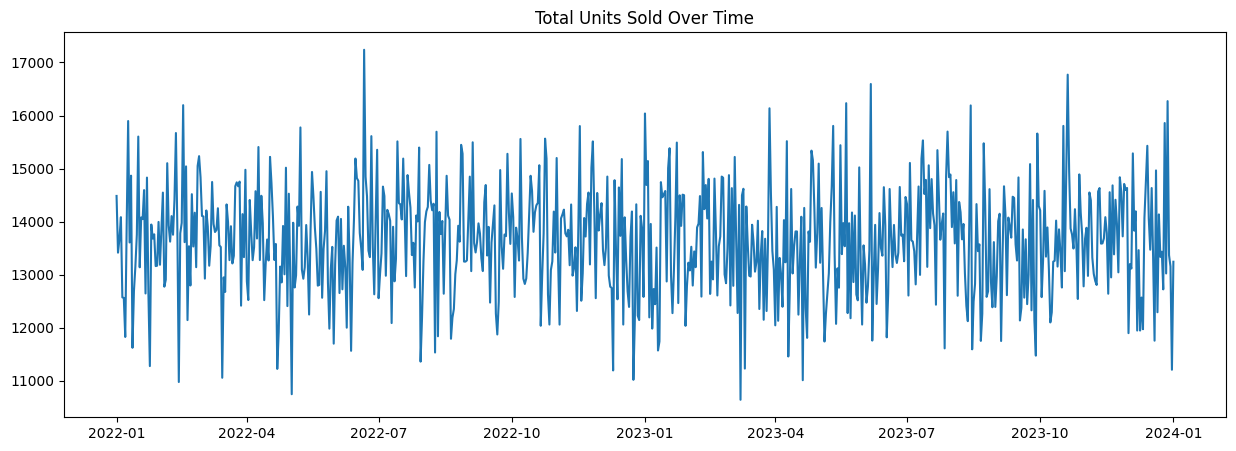

In [ ]:
# time-series: daily sold units
daily_sales = df.groupby('date')['units_sold'].sum()

plt.figure(figsize=(15,5))
plt.plot(daily_sales)
plt.title('Total Units Sold Over Time')
plt.show()

> Visualisasi line plot menunjukkan tren penjualan harian. Data ini didapatkan dengan mengelompokkan data penjualan (`units_sold`) berdasarkan tanggal (`date`). Hasilnya memperlihatkan bahwa penjualan harian bersifat fluktuatif tetapi masih cukup konsisten tanpa adanya tren jangka panjang yang signifikan.
Meskipun ada beberapa titik puncak (*spike*) dan lembah, pola secara umum tidak menunjukkan pergerakan naik atau turun yang signifikan.

> Catatan: visualisasi ini tidak dipisahkan berdasarkan `store_id` sehingga mewakili keseluruhan *dataset*.

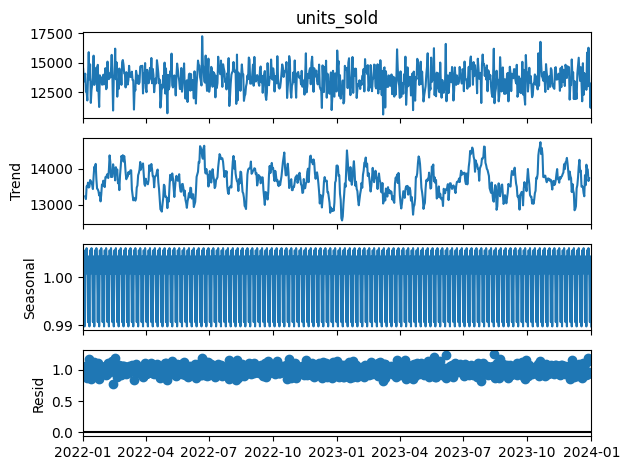

In [ ]:
# time-series: daily units sold decomposition
seasonal = seasonal_decompose(daily_sales, model='multiplicative', period=7)
seasonal.plot()
plt.show()

> Visualisasi ini memecah data `units_sold` harian menggunakan pendekatan **multiplicative** dengan periode 7 (**mingguan**).
- **Observed**: Menampilkan data penjualan aktual tanpa modifikasi. Terlihat adanya fluktuatif dengan beberapa puncak dan lembah pada beberapa titik, tetapi tidak menunjukkan tren yang cukup signifikan. Meskipun demikian, terdapat pola berulang yang terlihat cukup konsisten.
- **Trend**: Menampilkan tren jangka panjang yang relatif stabil, dengan sedikit fluktuasi halus yang bisa disebabkan oleh faktor musiman atau promosi.
- **Seasonal**: Menunjukkan pola mingguan yang konsisten, dengan amplitudo kecil (sekitar 0.99-1.01), menandakan bahwa efek musiman terhadap penjualan harian relatif kecil.
- **Residual**: Merupakan komponen *noise* setelah tren dan musiman dihapus. Nilainya tersebar merata di sekitar 1.0, menandakan model berhasil menangkap sebagian besar pola dalam data.

> Kesimpulan: Tren jangka panjang cenderung stabil, tetapi variasi mingguan pada penjualan relatif kecil. Residual juga rendah yang menunjukkan bahwa mayoritas variasi dalam data dapat dijelaskan oleh pola tren dan musiman.

### **Multivariate Analysis**

> Bagian ini berisi analisis untuk memahami hubungan antarfitur, baik numerik maupun kategorikal, yang dapat membantu dalam pemilihan fitur saat pemodelan.

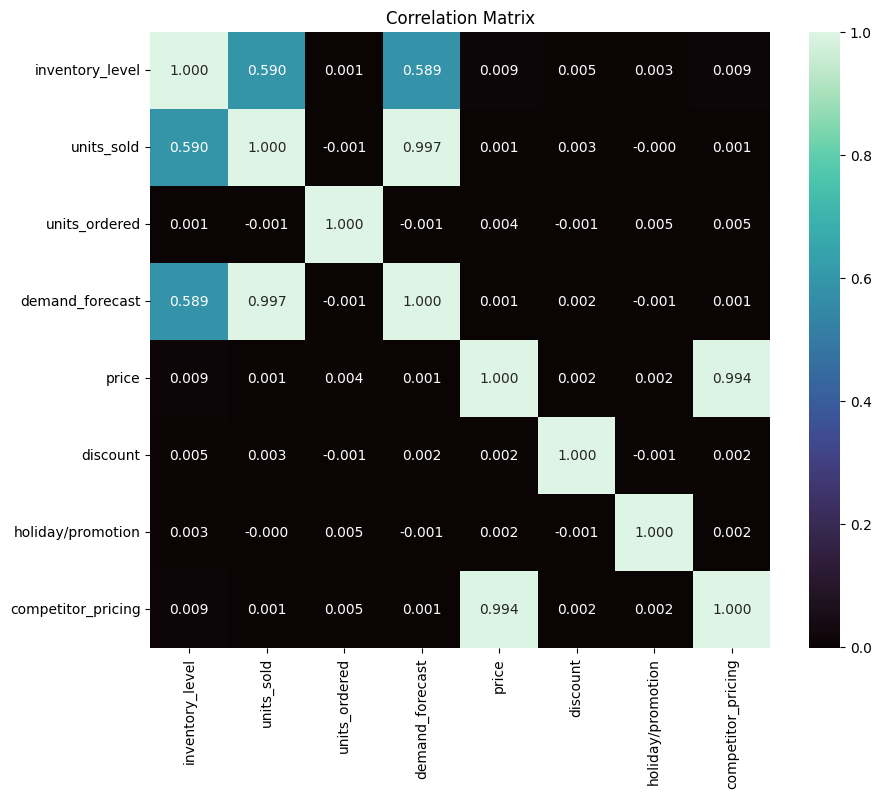

In [ ]:
# correlation heatmap
plt.figure(figsize=(10, 8))

corr_matrix = df[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='mako', fmt='.3f')

plt.title('Correlation Matrix')
plt.show()

> Visualisasi heatmap menunjukkan bahwa `demand_forecast` memiliki korelasi yang sangat tinggi dengan `units_sold`, hampir mendekati 1. Meskipun korelasi tinggi antarfitur biasanya dihindari karena risiko *multicollinearity*, dalam kasus ini, `demand_forecast` adalah fitur dan `units_sold` adalah target yang membuat korelasi tinggi ini justru bermanfaat dan dapat meningkatkan performa model.

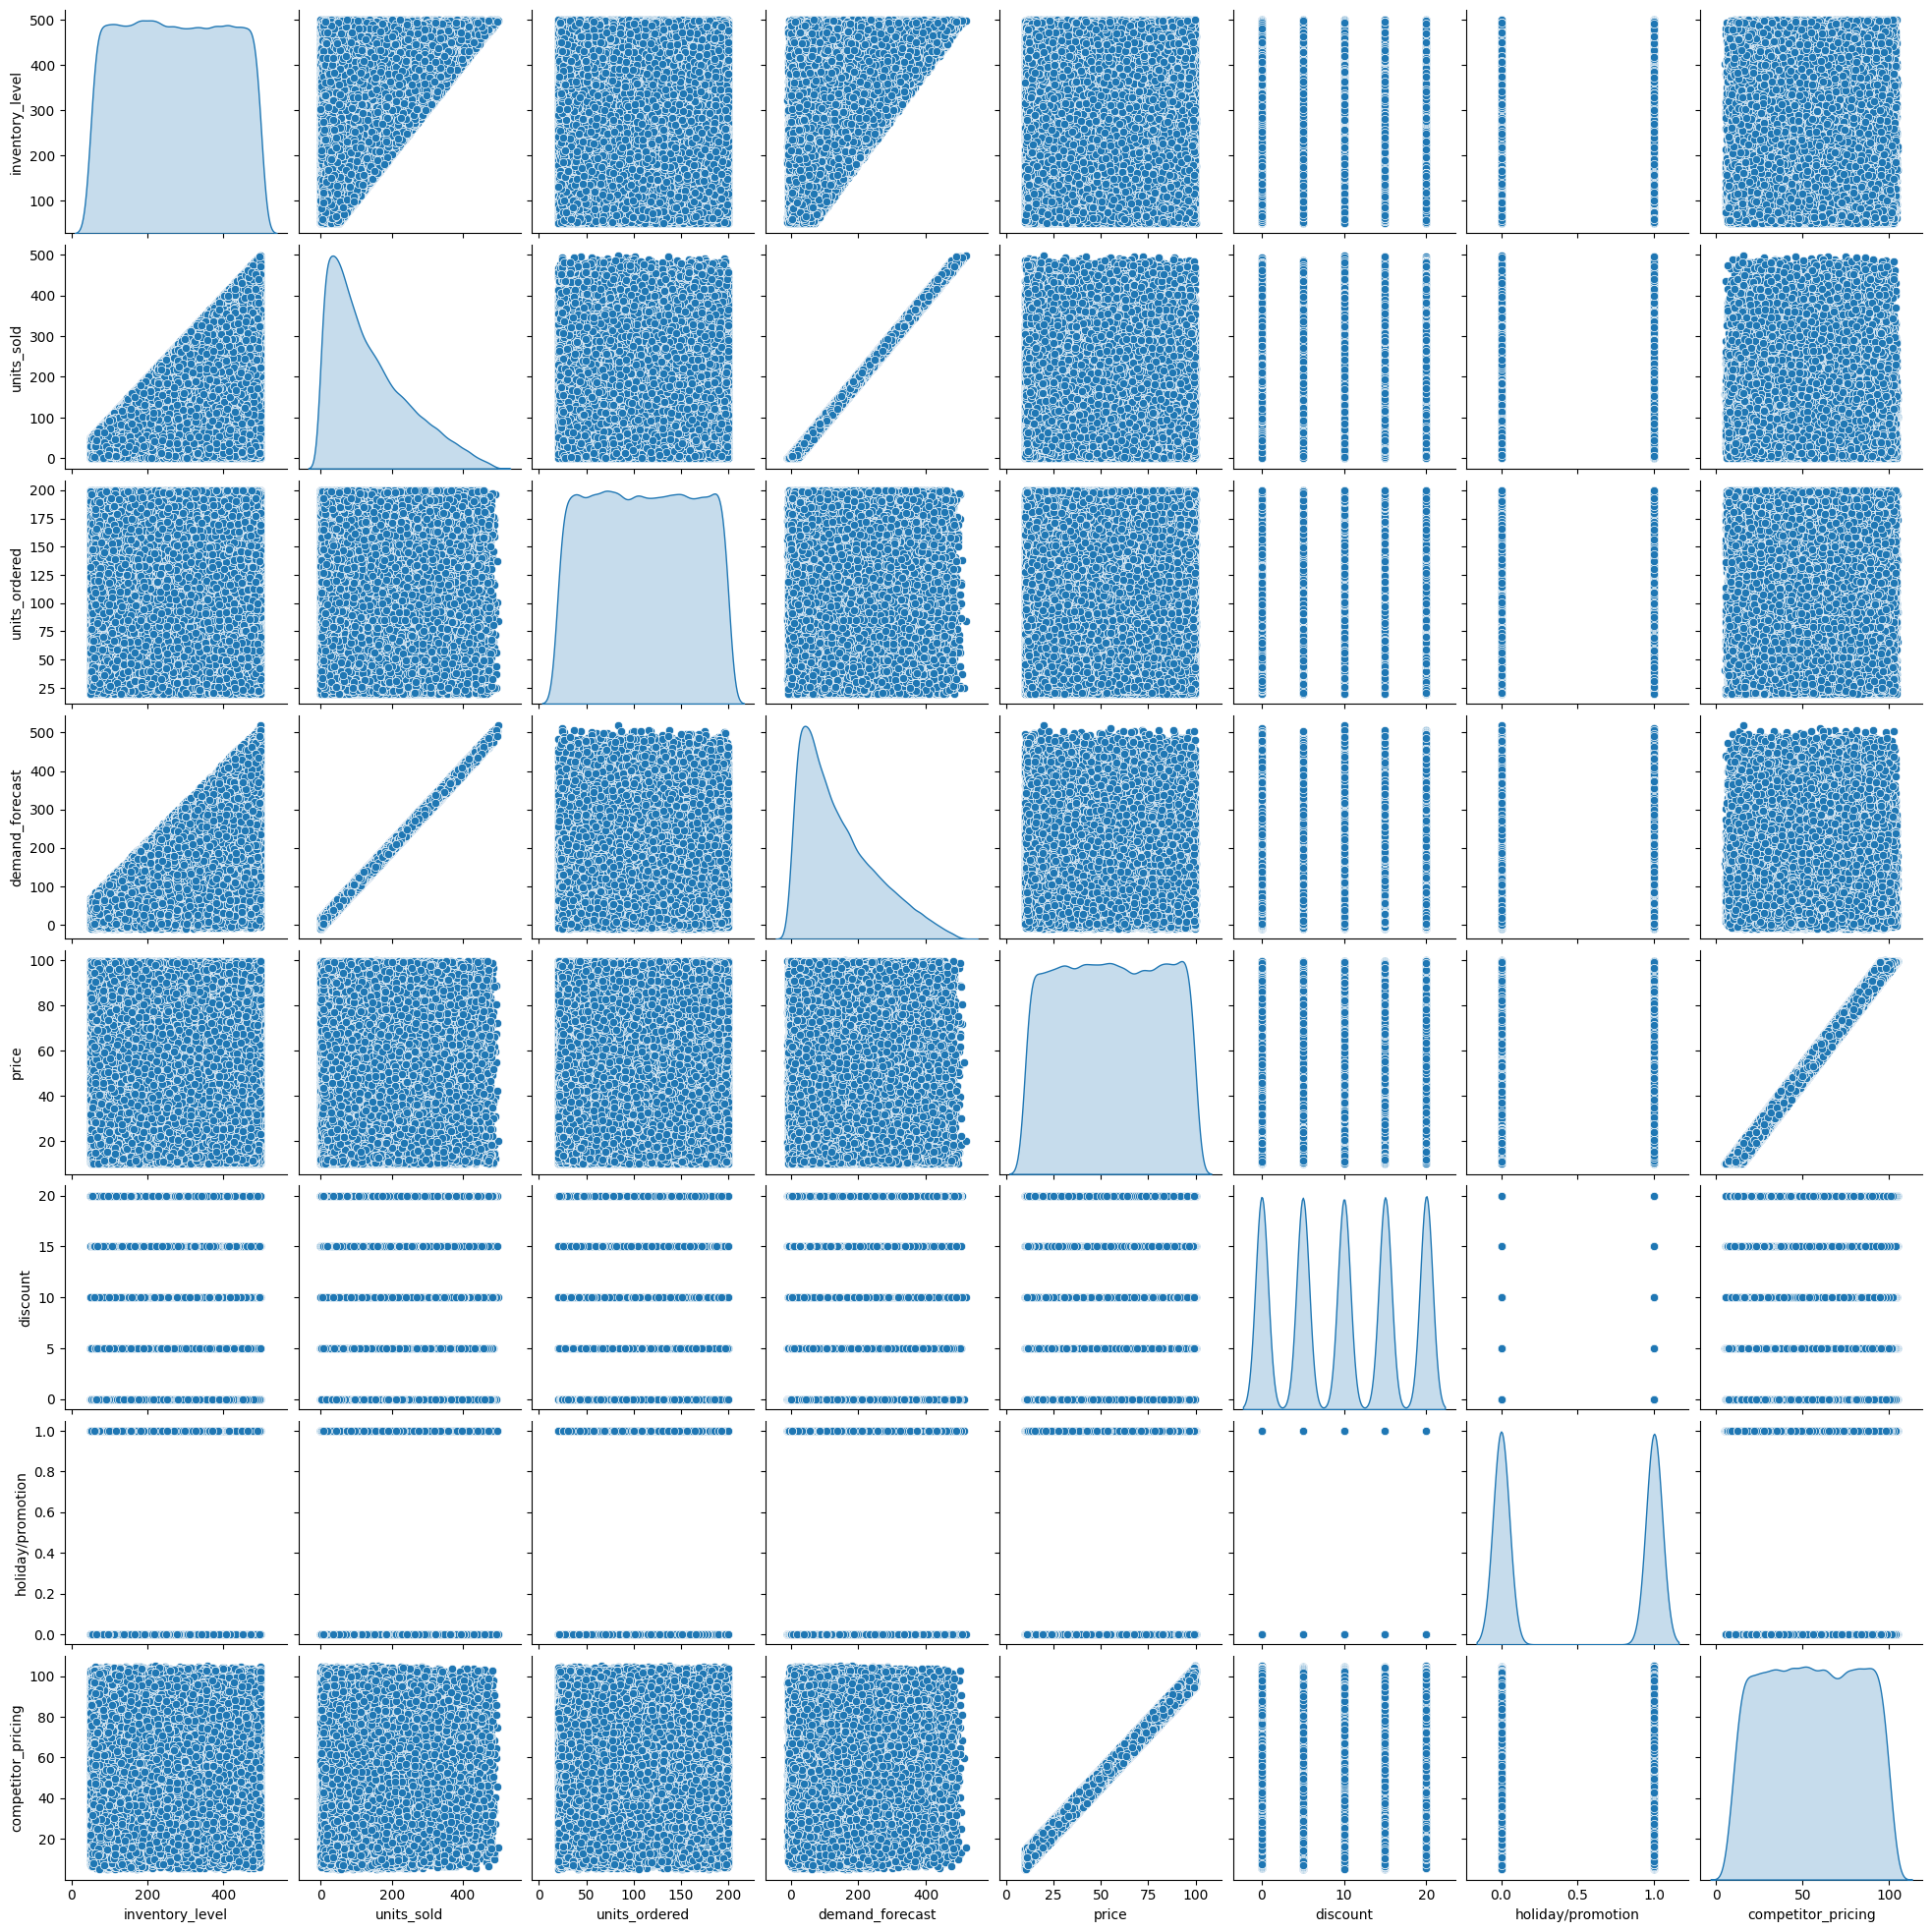

In [ ]:
# pairplot
sns.pairplot(df, diag_kind='kde')

> Berdasarkan pairplot, hanya `inventory_level` dan `demand_forecast` yang menunjukkan pola hubungan linear positif dengan `units_sold`. Hal ini menunjukkan bahwa kedua fitur tersebut memiliki potensi kuat dalam menjelaskan variasi nilai target. Fitur numerik lainnya tidak menunjukkan pola korelasi yang signifikan terhadap target.

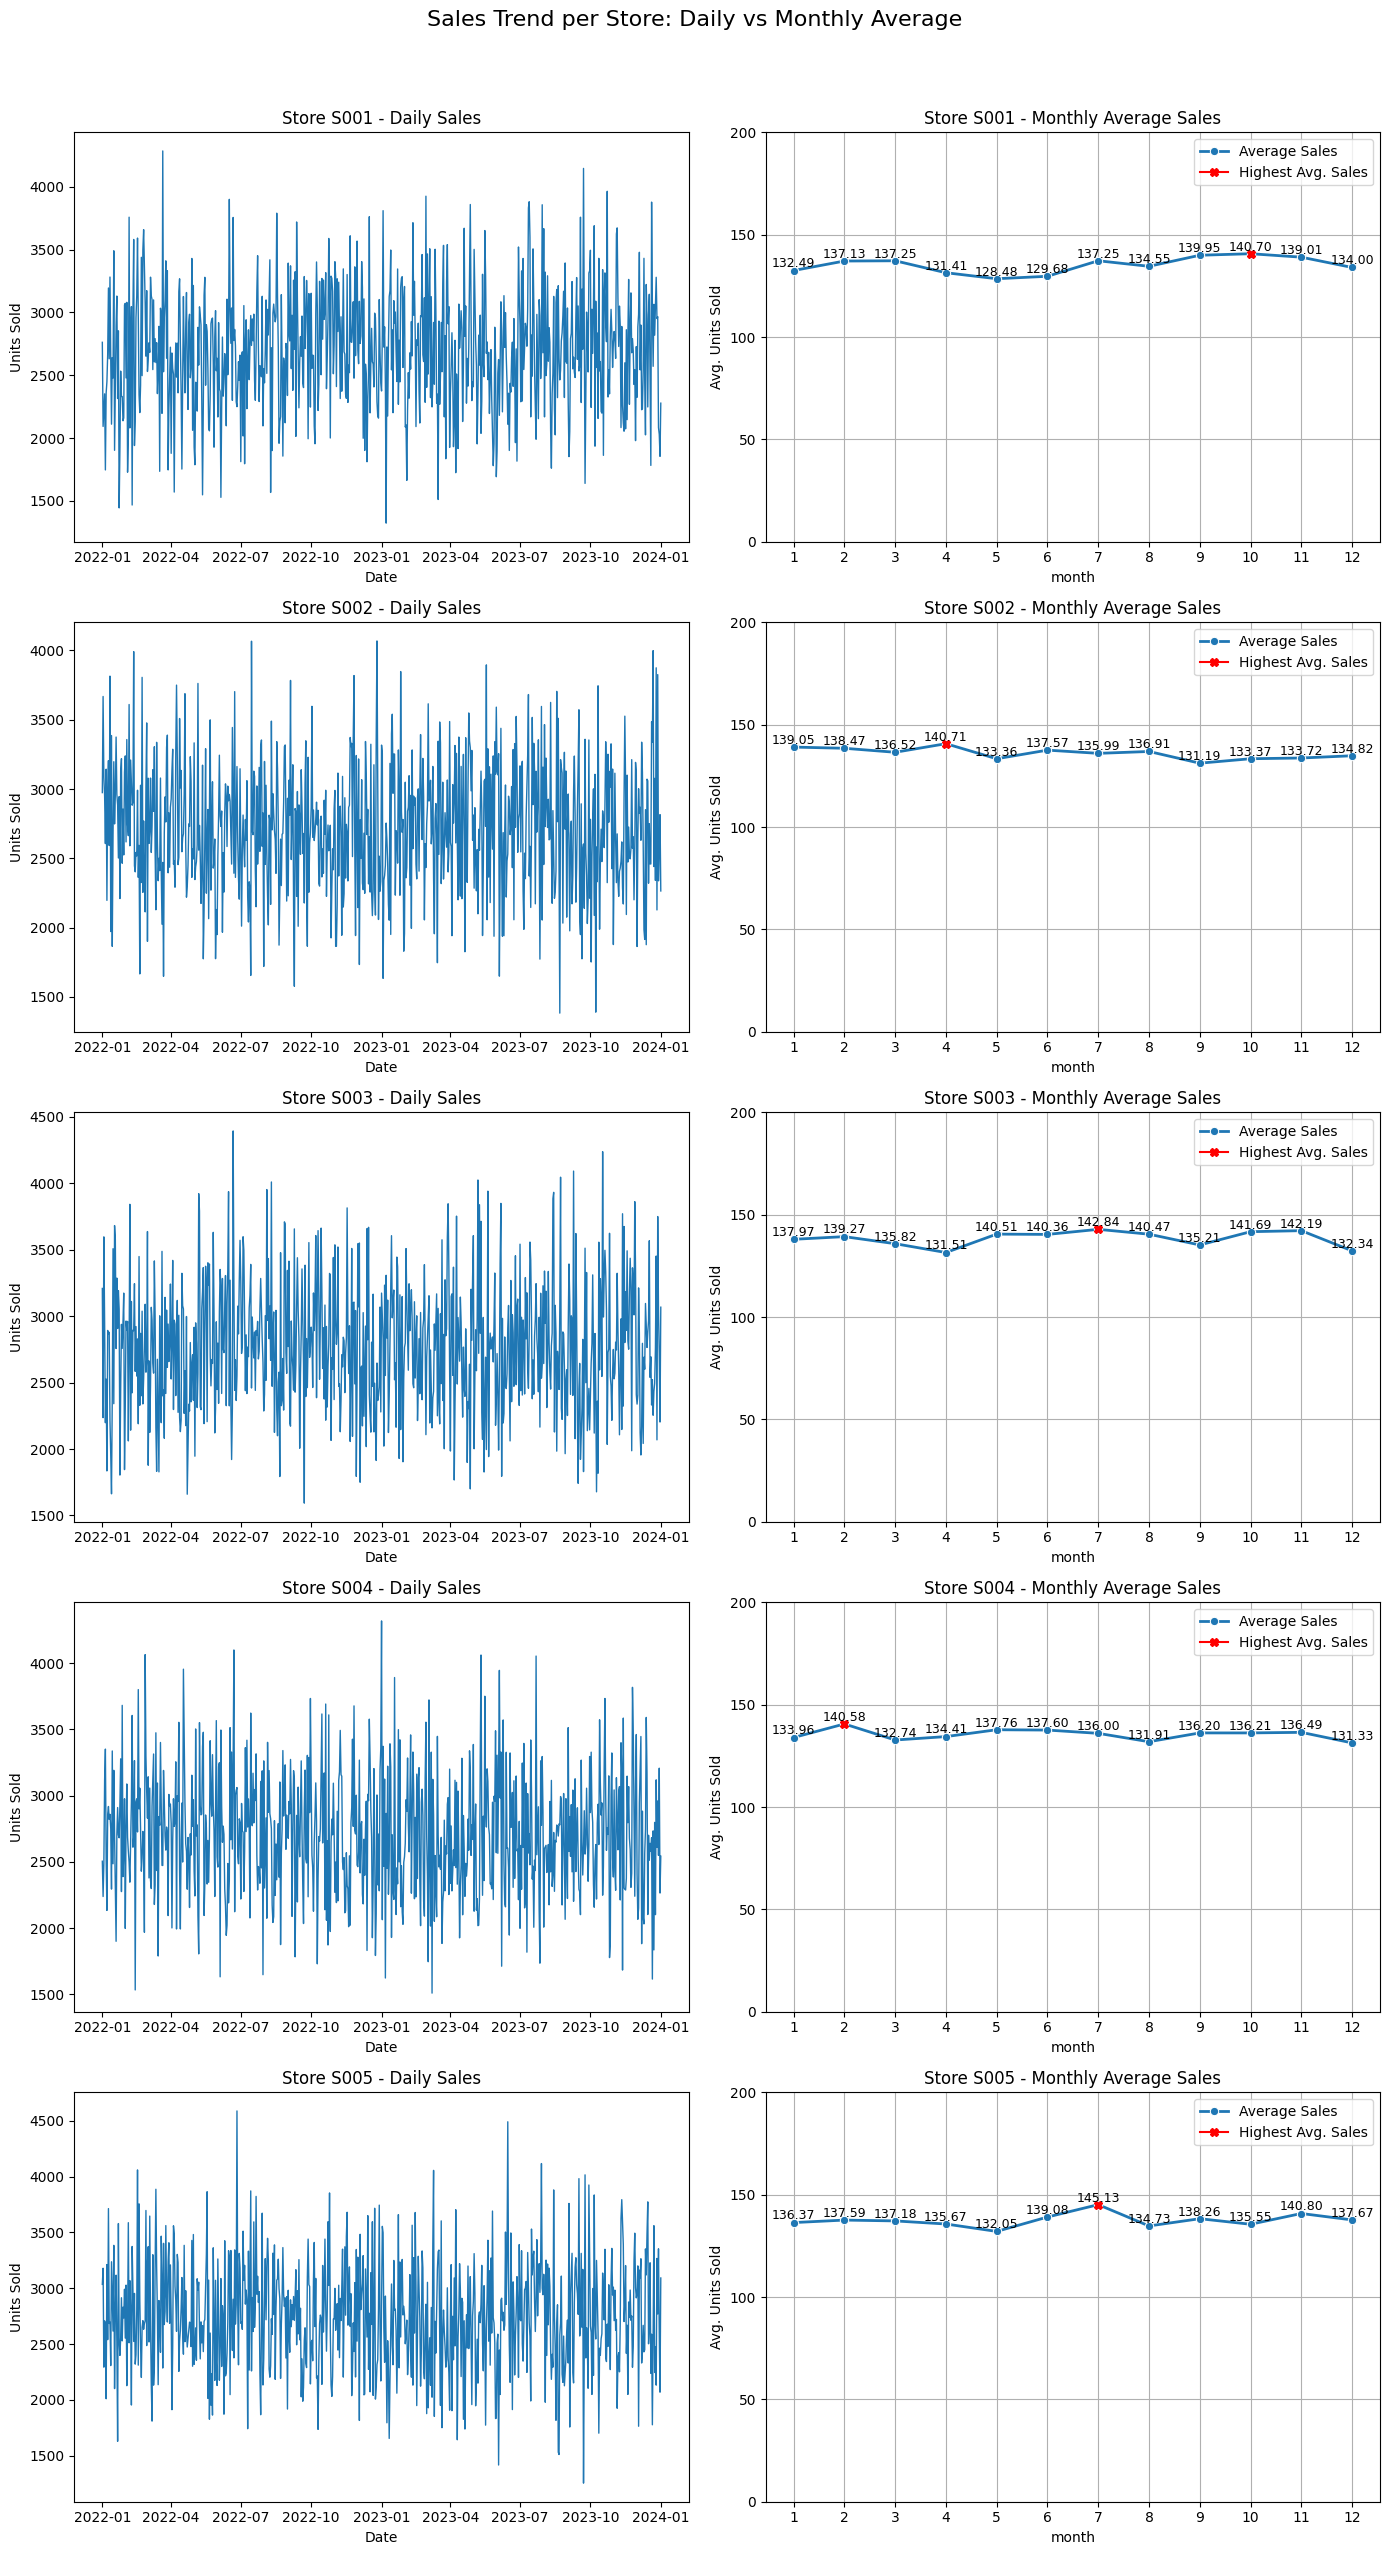

In [ ]:
# plot daily sales and monthly average sales across all stores
df['month'] = df['date'].dt.month # create a new column for month

daily_sales_per_store = df.groupby(['date', 'store_id'])['units_sold'].sum().reset_index()
monthly_avg_sales_per_store = df.groupby(['month', 'store_id'])['units_sold'].mean().reset_index()

# get unique ids for every store
store_ids = sorted(df['store_id'].unique())

# create the subplot
fig, axes = plt.subplots(nrows=len(store_ids), ncols=2, figsize=(14,25), sharey=False)
fig.subplots_adjust(hspace=0.5)

# get daily and monthly avg sales per store
for i, store in enumerate(store_ids):
  daily_data = daily_sales_per_store[daily_sales_per_store['store_id'] == store]
  monthly_data = monthly_avg_sales_per_store[monthly_avg_sales_per_store['store_id'] == store]

  # set y-axis limits and ticks for consistency
  max_y = monthly_data['units_sold'].max()
  step = 50
  upper_limit = (int(max_y // step) + 2) * step

  # --- daily sales ---
  ax_daily = axes[i, 0]
  sns.lineplot(data=daily_data, x='date', y='units_sold', ax=ax_daily, linewidth=1)

  ax_daily.set_title(f'Store {store} - Daily Sales')
  ax_daily.set_ylabel('Units Sold')
  ax_daily.set_xlabel('Date')

  # --- monthly average sales ---
  # get the month with the highest average sales
  max_idx = monthly_data['units_sold'].idxmax()
  max_month = monthly_data.loc[max_idx, 'month']
  max_sales = monthly_data.loc[max_idx, 'units_sold']

  ax_monthly = axes[i, 1]
  sns.lineplot(data=monthly_data, x='month', y='units_sold', marker='o', ax=ax_monthly, linewidth=2, label='Average Sales')
  ax_monthly.plot(max_month, max_sales, marker='X', color='red', label='Highest Avg. Sales')

  ax_monthly.set_title(f'Store {store} - Monthly Average Sales')
  ax_monthly.set_ylabel('Avg. Units Sold')
  ax_monthly.grid(True)
  ax_monthly.legend()
  ax_monthly.set_ylim(0, upper_limit)
  ax_monthly.set_xticks(range(1,13), [str(m) for m in range(1,13)])
  ax_monthly.set_yticks(range(0, upper_limit+1, step))

  # annotation
  for j, row in monthly_data.iterrows():
    ax_monthly.text(x=row['month'], y=row['units_sold'] + 0.07, s=f"{row['units_sold']:.2f}",
                 ha='center', va='bottom', fontsize=9)

plt.suptitle('Sales Trend per Store: Daily vs Monthly Average', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

> Visualisasi di atas menampilkan tren penjualan harian (sebelah kiri) dan tren rata-rata penjualan bulanan (sebelah kanan) pada setiap toko. Berikut *insights* yang didapatkan:
- **Daily Sales**: semua toko menunjukkan **fluktuasi penjualan yang cukup konsisten** selama periode pengamatan (*observed*), dengan pola naik-turun yang cenderung mirip. Tidak terdapat anomali besar ataupun nilai yang terlau ekstrem yang menandakan operasional toko yang cenderung stabil.
- **Monthly Average Sales**: Rata-rata penjualan bulanan per toko berkisar antara 133-146 unit. Terlihat tren **cenderung seragam** dengan beberapa lonjakan yang tidak ekstrem pada bulan tertentu, seperti pada bulan Oktober di store S001, April di store S002, Juli di store S003 dan S005, serta Februari di store S004. Hal ini menunjukkan penjualan yang **relatif stabil** dari bulan ke bulan.

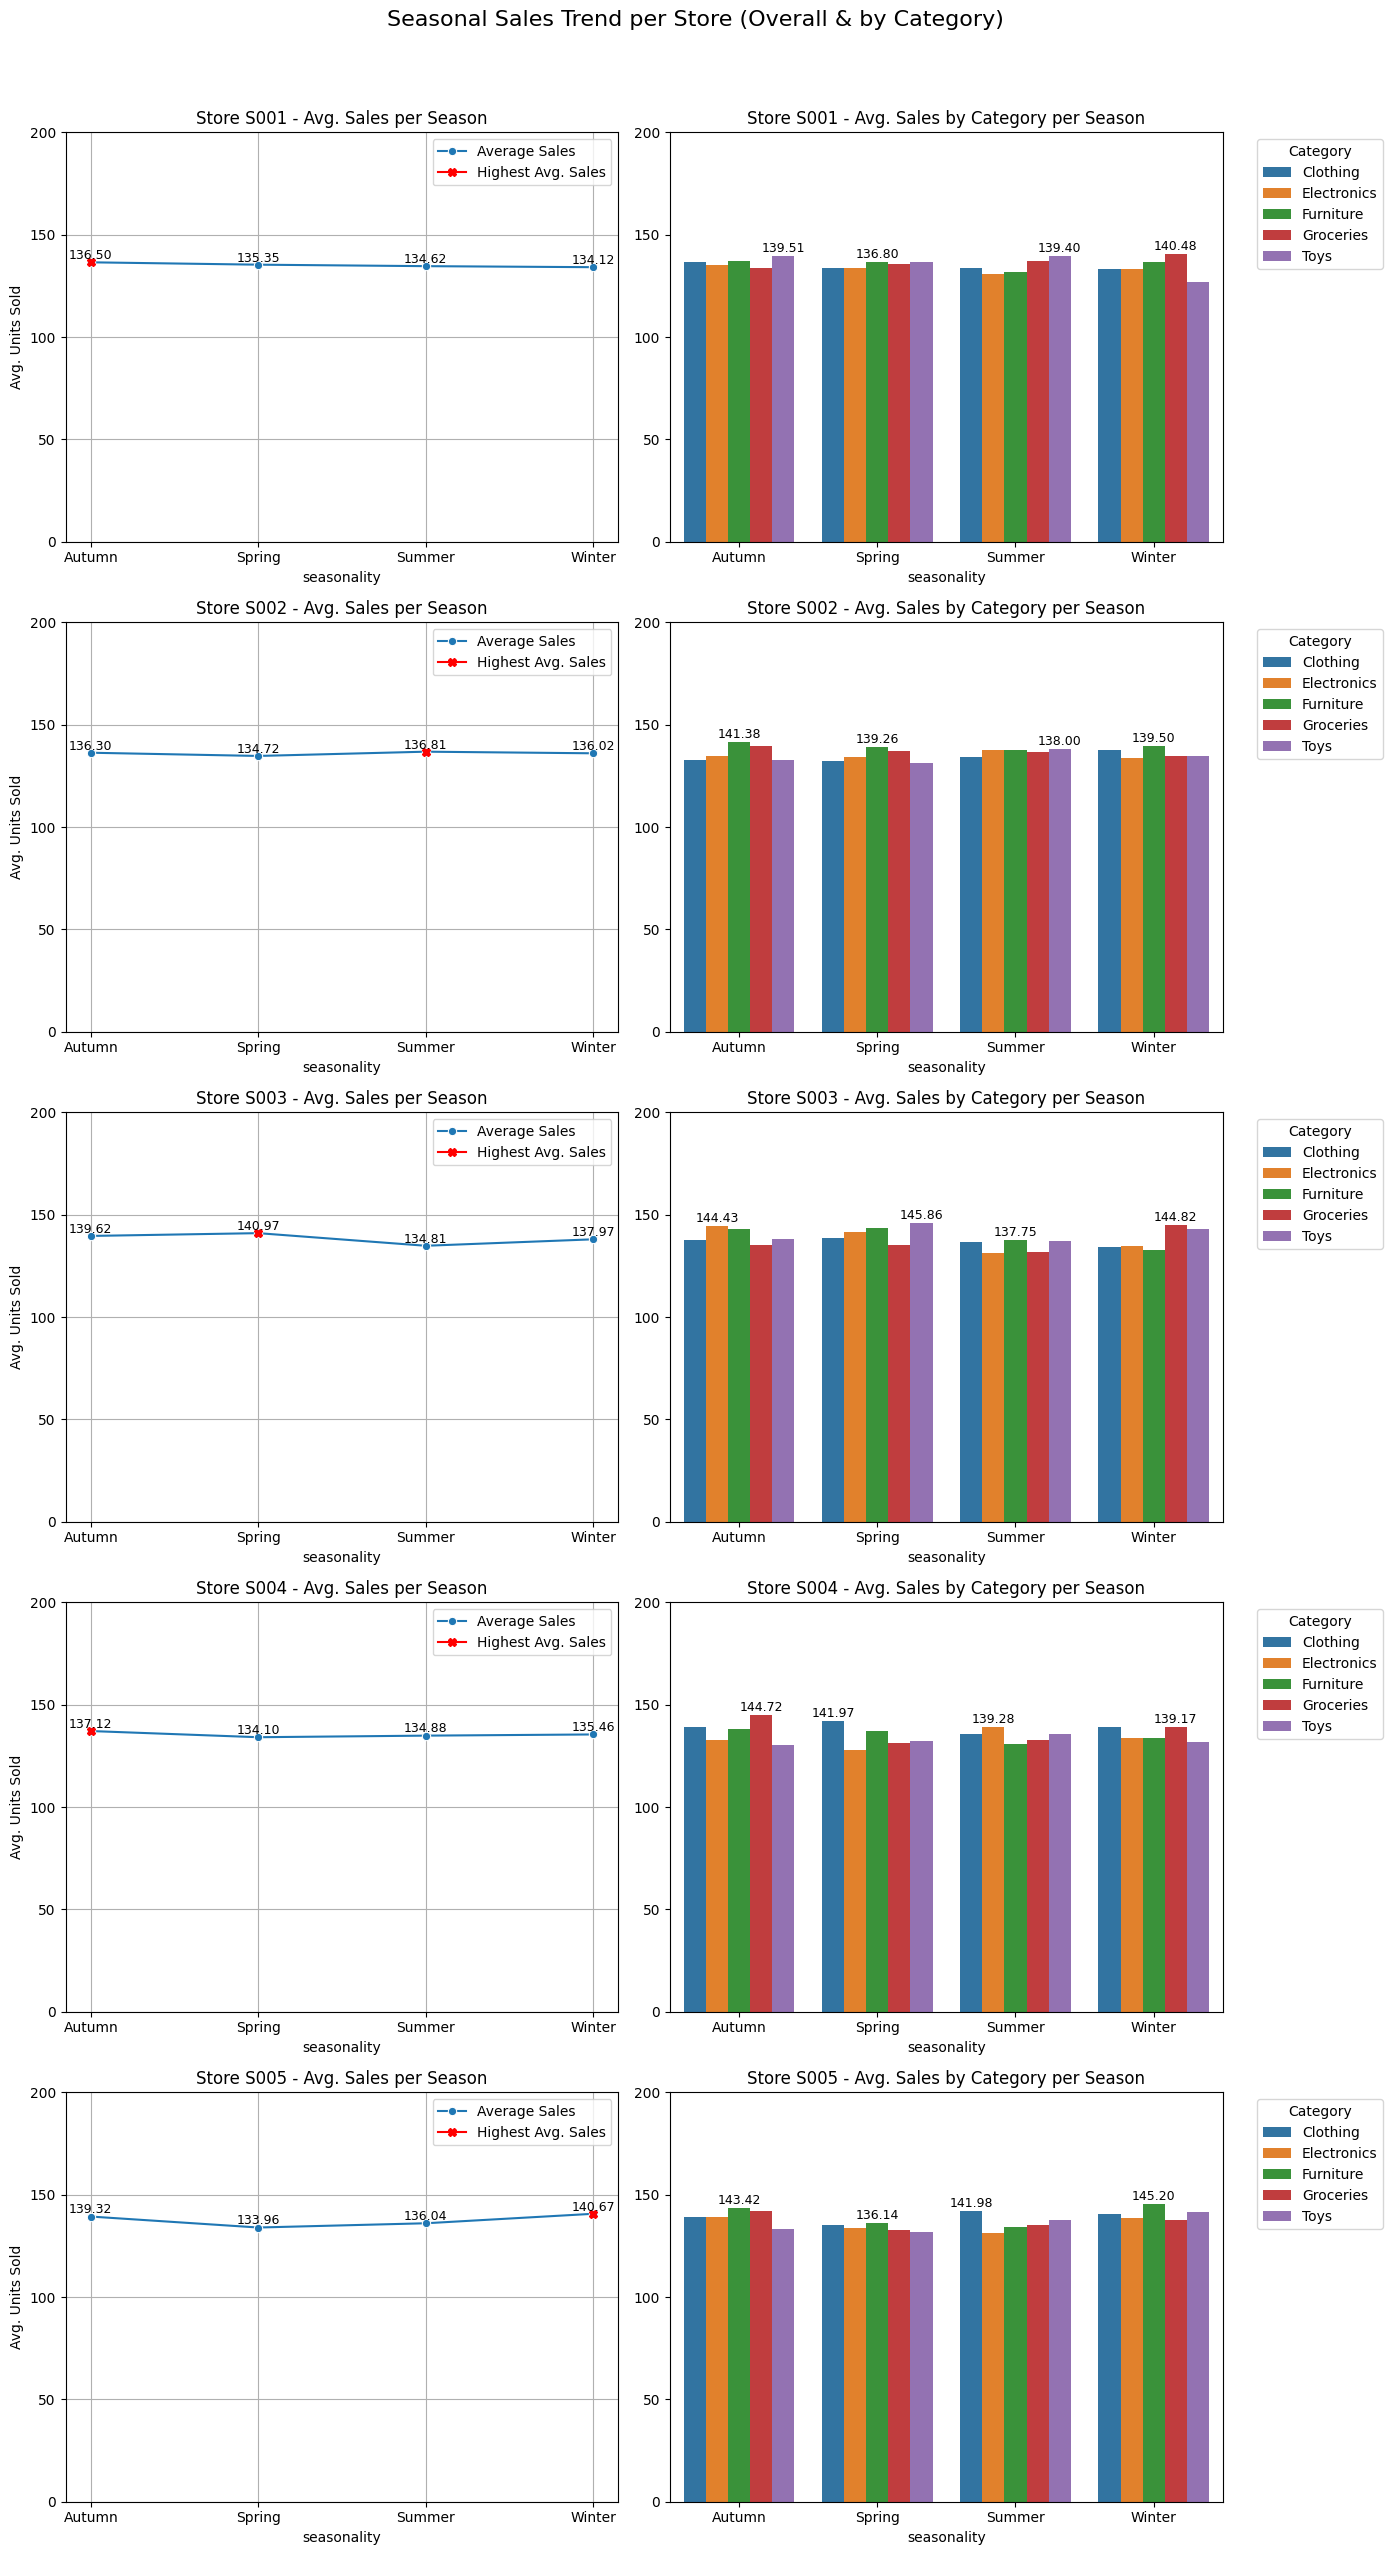

In [ ]:
# plot average seasonal sales trend overall and per category across all stores
seasonal_avg_per_store = df.groupby(['seasonality', 'store_id'])['units_sold'].mean().reset_index()
seasonal_cat_avg_per_store = df.groupby(['seasonality', 'store_id', 'category'])['units_sold'].mean().reset_index()

# get unique ids for every store
store_ids = sorted(df['store_id'].unique())

# create the subplot
fig, axes = plt.subplots(nrows = len(store_ids), ncols=2, figsize=(14,25), sharey='col')
fig.subplots_adjust(hspace=0.5)

# get the data for line plot and the bar plot
for i, store in enumerate(store_ids):
  line_data = seasonal_avg_per_store[seasonal_avg_per_store['store_id'] == store]
  bar_data = seasonal_cat_avg_per_store[seasonal_cat_avg_per_store['store_id'] == store]

  # set y-axis limits and ticks for consistency
  max_y = max(
      line_data['units_sold'].max(),
      bar_data['units_sold'].max()
      )
  step = 50
  upper_limit = (int(max_y // step) + 2) * step

  # --- line plot ---
  # get the season with highest sales (by average)
  max_idx =  line_data['units_sold'].idxmax()
  max_season = line_data.loc[max_idx, 'seasonality']
  max_sales = line_data.loc[max_idx, 'units_sold']

  ax_line = axes[i, 0]
  sns.lineplot(data=line_data, x='seasonality', y='units_sold', marker='o', ax=ax_line, label='Average Sales')
  ax_line.plot(max_season, max_sales, marker='X', color='red', label='Highest Avg. Sales')

  ax_line.set_title(f'Store {store} - Avg. Sales per Season')
  ax_line.set_ylabel('Avg. Units Sold')
  ax_line.grid(True)
  ax_line.legend()

  ax_line.set_ylim(0, upper_limit)
  ax_line.set_yticks(range(0, upper_limit+1, step))

  # line plot annotation
  for j, row in line_data.iterrows():
    ax_line.text(x=row['seasonality'], y=row['units_sold'] + 0.07, s=f"{row['units_sold']:.2f}",
                 ha='center', va='bottom', fontsize=9)

  # --- bar plot ---
  ax_bar = axes[i, 1]
  bar = sns.barplot(data=bar_data, x='seasonality', y='units_sold', hue='category', ax=ax_bar)

  ax_bar.set_title(f'Store {store} - Avg. Sales by Category per Season')
  ax_bar.set_ylabel('')
  ax_bar.legend(title='Category', bbox_to_anchor=(1.05,1))

  ax_bar.set_ylim(0, upper_limit)
  ax_bar.set_yticks(range(0, upper_limit+1, step))

  # bar plot annotation - highest avg category sales per season
  for season in bar_data['seasonality'].unique():
    # get only the highest units sold per season
    season_subset = bar_data[bar_data['seasonality'] == season]
    max_row = season_subset.loc[season_subset['units_sold'].idxmax()]

    for bar in ax_bar.patches:
      bar_x_centered = bar.get_x() + bar.get_width() / 2
      bar_height = bar.get_height()

      # check if the bar's current height matches the value of max_row['units_sold'] and if the season matches
      if (abs(bar_height - max_row['units_sold']) < 1e-2 and season in max_row['seasonality']):
        # give annotation to the category with the highest average units sold
        ax_bar.text(
            bar_x_centered, bar_height + 0.5, f"{bar_height:.2f}",
            ha='center', va='bottom', fontsize=9
        )
        break # only one annotation per season

plt.suptitle('Seasonal Sales Trend per Store (Overall & by Category)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

> Visualisasi di atas menampilkan tren rata-rata penjualan per musim (sebelah kiri) dan distribusi kategori yang dibeli pada musim tersebut (sebelah kanan) pada setiap toko. Berikut *insights* yang didapatkan:
- **Seasonal Average Sales**: rata-rata penjualan per musim cenderung seragam di semua toko, dengan selisih kecil antara musim satu dan lainnya. Hal ini mengindikasikan bahwa penjualan tidak terlalu terpengaruh oleh musim atau cuaca (tidak musiman).
- **Average Sales by Category**: tidak terdapat kategori yang mendominasi pada musim tertentu. Semua kategori (`Clothing`, `Electronics`, `Furniture`, `Groceries`, dan `Toys`) menunjukkan pola yang seimbang dan seragam sepanjang musim. Hal ini memperkuat temuan bahwa tidak terdapat pengaruh musiman yang signifikan per kategori terhadap penjualan per toko.

## **Data Preprocessing**

> Pada bagian ini dilakukan berbagai tahapan *data preprocessing*, yaitu:
- Memeriksa dan menangani ***missing values***
- Memeriksa dan menangani ***duplicated data***
- Memeriksa dan menangani ***outliers***
- Melakukan penggabungan fitur (***feature extraction***)
- **Memisahkan data** menjadi data latih dan data uji berdasarkan urutan tanggal
- Membuat ***preprocessing pipeline*** yang akan diaplikasikan pada data latih dan data uji secara terpisah, yang mencakup:
  - ***Encoding*** terhadap data kategorikal
  - ***Imputing*** terhadap *missing values* pada fitur hasil *feature extraction*
  - **Standardisasi** kolom numerik

> Seluruh tahapan ini dilakukan untuk memastikan data yang digunakan pada tahapan pemodelan sudah bersih dan layak digunakan guna meningkatkan performa model.

### **Missing Values**

In [ ]:
# check the presence of null values
df.isnull().sum()

date                  0
store_id              0
product_id            0
category              0
region                0
inventory_level       0
units_sold            0
units_ordered         0
demand_forecast       0
price                 0
discount              0
weather_condition     0
holiday/promotion     0
competitor_pricing    0
seasonality           0
month                 0
dtype: int64

> Proses pemeriksaan *missing values* menggunakan sintaks `df.isnull().sum()`. Tabel di atas menunjukkan bahwa semua kolom tidak memiliki *missing values* yang terlihat dari nilai 0 di seluruh kolom. Dengan demikian, tidak diperlukan penanganan lebih lanjut untuk hal ini.

### **Duplicated Data**

In [ ]:
# check the presence of duplicated data
df.duplicated().sum()

np.int64(0)

> Pemeriksaan duplikasi data dilakukan menggunakan sintaks `df.duplicated().sum()`. Hasil menunjukkan nilai 0, yang berarti tidak terdapat data duplikat dalam *dataset*. Oleh karena itu, tidak ada tindakan khusus yang diperlukan.

### **Outliers**

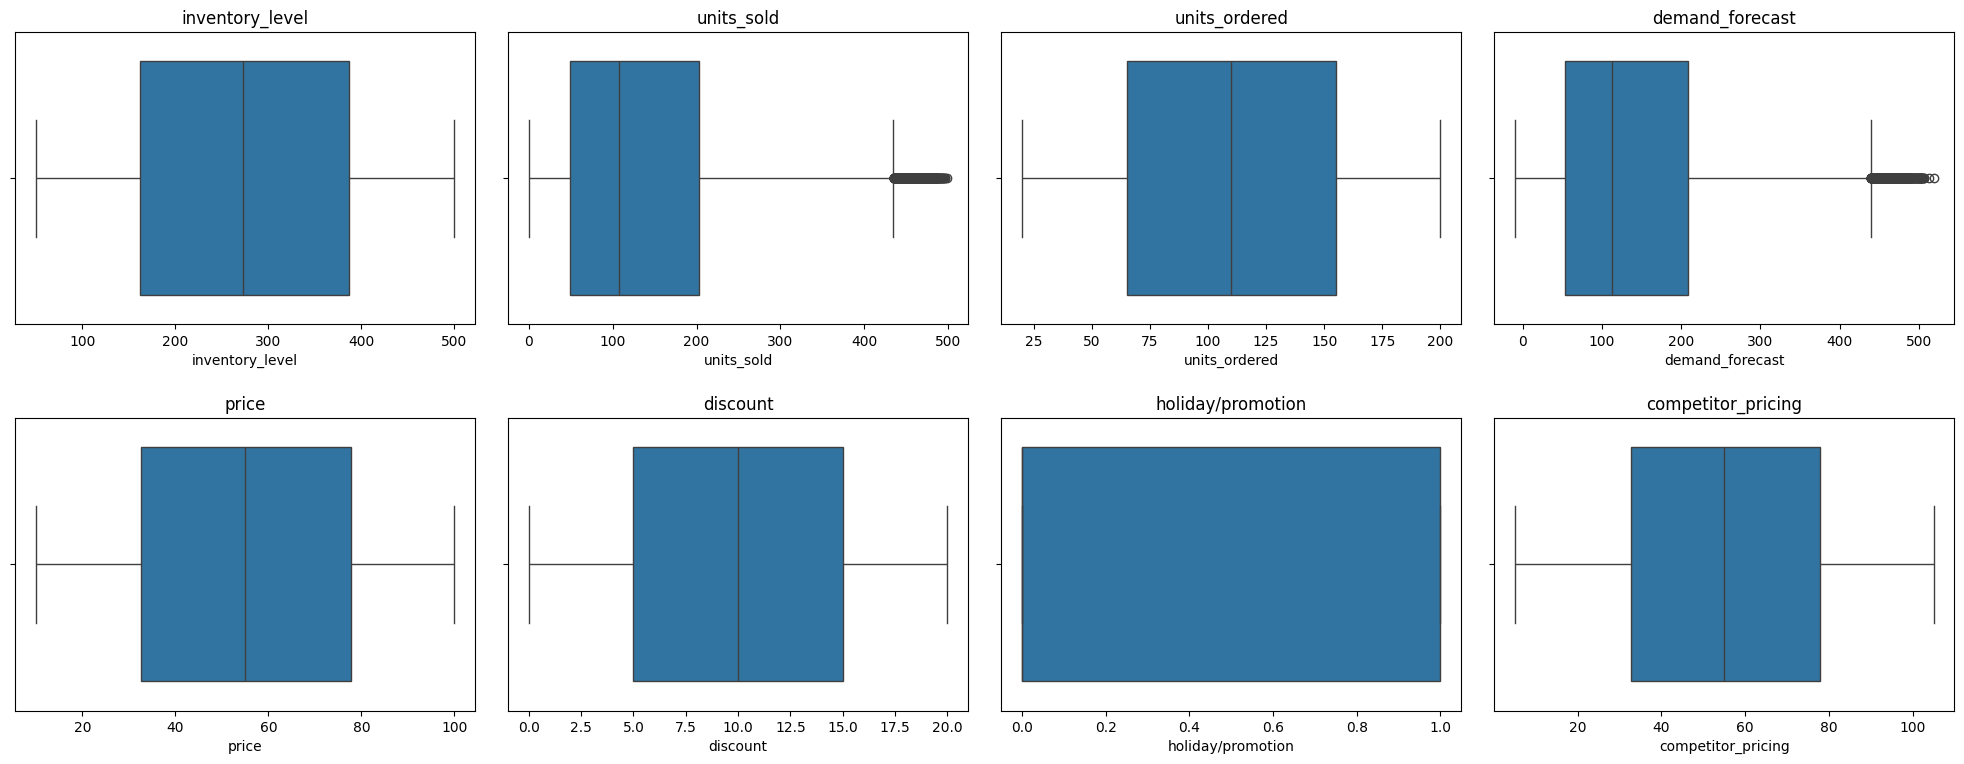

In [ ]:
# display outliers
plot_outliers(df, num_cols)

> Pemanggilan fungsi `plot_outliers()` menghasilkan visualisasi *boxplot* untuk setiap kolom numerik guna mengidentifikasi keberadaan *outliers*. Dari visualisasi, terlihat bahwa kolom `units_sold` dan `demand_forecast` memiliki *outliers* dengan distribusi data yang cukup *skewed*. *Outliers* tersebut berada di atas batas atas (*upper boundary*), menunjukkan tingginya *demand* yang tidak biasa. Selanjutnya dilakukan analisis lanjutan untuk menyelidiki kemungkinan penyebabnya.

In [ ]:
# function to store outliers info, such as count, rub, & rlb
def outliers_info(df):
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)

  # IQR formula
  IQR = Q3 - Q1
  RLB = Q1 - (1.5 * IQR)
  RUB = Q3 + (1.5 * IQR)

  # count outliers
  count = 0
  for x in df:
    if (x < RLB) or (x > RUB):
      count += 1

  return count, RLB, RUB

> Fungsi `outliers_info()` menghitung jumlah *outlier* dalam setiap kolom numerik dan menyimpan informasi terkait jumlah *outlier*, batas bawah (RLB), dan batas atas (RUB). Perhitungan *outlier* menggunakan Tukey's Rule, yang didasarkan pada rentang interkuartil (IQR).

In [ ]:
# function to print outliers sorted by the column with the most outliers present
def print_outliers(df, num_arr):
  outliers_dict = dict() # a dictionary to store the column name and the number of outliers present

  # check outliers presence in every column
  for col in num_arr:
    total_outliers = outliers_info(df[col])[0] # function call: get outliers info

    # store columns with outliers into the dict
    if total_outliers > 0:
      outliers_dict[col] =  total_outliers

  # sort the dictionary by the number of outliers in descending order
  sorted_col_by_outliers = dict(sorted(outliers_dict.items(), key=lambda item: item[1], reverse=True))

  # print the result
  for k, v in sorted_col_by_outliers.items():
    total_data_percentage = round((v/len(df)) * 100, 3)
    print(f'Total outliers in {k} is {v} ({total_data_percentage}% of total data)')

  print(f'\nTotal column with outliers: {len(sorted_col_by_outliers)} out of {len(num_arr)}')

# function call
print_outliers(df, num_cols)

Total outliers in demand_forecast is 732 (1.001% of total data)
Total outliers in units_sold is 715 (0.978% of total data)

Total column with outliers: 2 out of 8


> Fungsi `print_outliers` memanggil fungsi `outliers_info` untuk menghitung jumlah *outlier* per kolom dan menampilkannya secara berurutan dari jumlah terbanyak. Kedua kolom memiliki jumlah *outlier* yang hampir sama dan hanya mencakup sekitar 1% dari keseluruhan data. Sebelum menentukan metode penanganannya, dilakukan analisis lanjutan menggunakan fitur-fitur lain.

#### **Analysis**

> Bagian ini berisikan analisis dengan memanfaatkan fitur lain untuk mengetahui kemungkinan penyebab *outliers*.

In [ ]:
# display the outliers data of column units_sold
threshold_upper = outliers_info(df['units_sold'])[2] # get RUB value
df_outliers = df.loc[df['units_sold'] > threshold_upper] # filter data to only include outliers
df_outliers

date store_id product_id     category region  inventory_level  \
102   2022-01-02     S001      P0003     Clothing  South              488   
138   2022-01-02     S002      P0019         Toys   East              492   
195   2022-01-02     S005      P0016    Groceries   East              487   
322   2022-01-04     S002      P0003         Toys  North              493   
554   2022-01-06     S003      P0015    Furniture  North              490   
...          ...      ...        ...          ...    ...              ...   
72428 2023-12-26     S002      P0009     Clothing  South              485   
72485 2023-12-26     S005      P0006    Groceries   West              498   
72567 2023-12-27     S004      P0008    Furniture   East              493   
72884 2023-12-30     S005      P0005    Furniture   East              498   
73060 2024-01-01     S004      P0001  Electronics   East              497   

       units_sold  units_ordered  demand_forecast  price  discount  \
102           464            163           463.12  70.99        10   
138           479            132           469.74  79.11         0   
195           437            106           432.86  43.64        15   
322           448            113           459.44  41.55        15   
554           476             53           478.76  20.66         0   
...           ...            ...              ...    ...       ...   
72428         453            172           444.97  82.93        15   
72485         482             33           488.92  34.79        10   
72567         441             79           435.81  91.84        20   
72884         472            169           485.17  95.79        20   
73060         496            137           489.62  42.34        15   

      weather_condition  holiday/promotion  competitor_pricing seasonality  \
102               Snowy                  0               72.93      Summer   
138              Cloudy                  0               80.06      Winter   
195              Cloudy                  1               39.13      Autumn   
322               Rainy                  0               44.02      Winter   
554               Rainy                  1               16.87      Winter   
...                 ...                ...                 ...         ...   
72428            Cloudy                  1               79.35      Autumn   
72485             Sunny                  1               31.68      Autumn   
72567             Rainy                  1               88.97      Summer   
72884             Sunny                  1               98.65      Summer   
73060             Snowy                  1               45.73      Spring   

       month  
102        1  
138        1  
195        1  
322        1  
554        1  
...      ...  
72428     12  
72485     12  
72567     12  
72884     12  
73060      1  

[715 rows x 16 columns]

> Kode di atas memfilter data yang termasuk *outliers* pada kolom `units_sold` dan menyimpannya dalam variabel `df_outliers` untuk keperluan analisis lebih lanjut.

In [ ]:
# descriptive statistics of df_outliers
df_outliers.describe(include='number')

inventory_level  units_sold  units_ordered  demand_forecast  \
count       715.000000  715.000000     715.000000       715.000000   
mean        478.630769  456.787413     111.404196       461.550643   
std          15.512556   15.265149      52.893241        17.544156   
min         436.000000  435.000000      20.000000       425.430000   
25%         468.000000  444.000000      68.000000       448.555000   
50%         481.000000  454.000000     112.000000       459.230000   
75%         491.500000  469.000000     158.000000       474.685000   
max         500.000000  499.000000     200.000000       518.550000   

            price    discount  holiday/promotion  competitor_pricing  \
count  715.000000  715.000000         715.000000          715.000000   
mean    53.028727   10.419580           0.465734           53.164042   
std     25.921168    6.993807           0.499174           26.053831   
min     10.030000    0.000000           0.000000            5.640000   
25%     31.645000    5.000000           0.000000           31.910000   
50%     50.480000   10.000000           0.000000           50.790000   
75%     75.125000   15.000000           1.000000           74.955000   
max     99.900000   20.000000           1.000000          103.170000   

            month  
count  715.000000  
mean     6.593007  
std      3.412074  
min      1.000000  
25%      4.000000  
50%      7.000000  
75%     10.000000  
max     12.000000

> Berdasarkan tabel statistik deskriptif, nilai terkecil pada `units_sold` dalam subset *outliers* adalah 435 dan terbesar 499, dengan median 454 dan rata-rata 456,8. Dalam data *outliers*, nilai ini tidak terpaut sangat jauh, tetapi menjadi *outliers* karena pada data keseluruhan, nilai minimumnya adalah 0, dengan rata-rata 136,5 dan median 107.

In [ ]:
# check if there are spikes on sales in certain month
df_outliers['month'].value_counts(normalize=True)

month
6     0.095105
8     0.090909
10    0.088112
12    0.086713
2     0.085315
4     0.083916
7     0.082517
9     0.079720
11    0.079720
5     0.078322
3     0.076923
1     0.072727
Name: proportion, dtype: float64

> Distribusi penjualan per bulan terlihat cukup merata, mengindikasikan bahwa lonjakan `units_sold` bukan disebabkan oleh faktor musiman atau liburan.

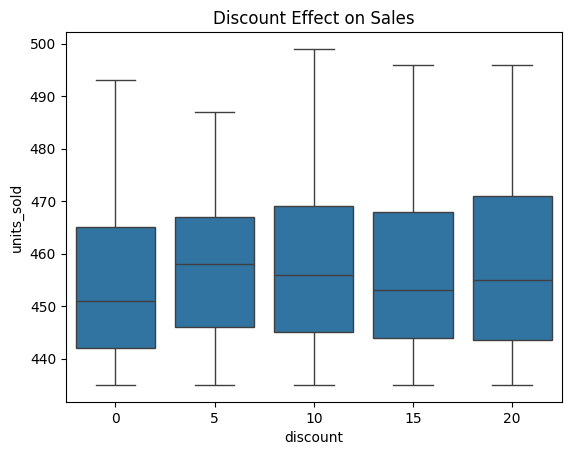

In [ ]:
# check if discount affects outliers
sns.boxplot(data=df_outliers, x='discount', y='units_sold')
plt.title('Discount Effect on Sales')
plt.show()

> Dari *boxplot* yang menampilkan kolom `discount`, terlihat bahwa variabel ini tidak menghasilkan *outliers* secara signifikan pada `units_sold`. Hal ini menunjukkan bahwa pengaruhnya terhadap lonjakan penjualan relatif kecil dan hanya berdampak pada distribusi umum.

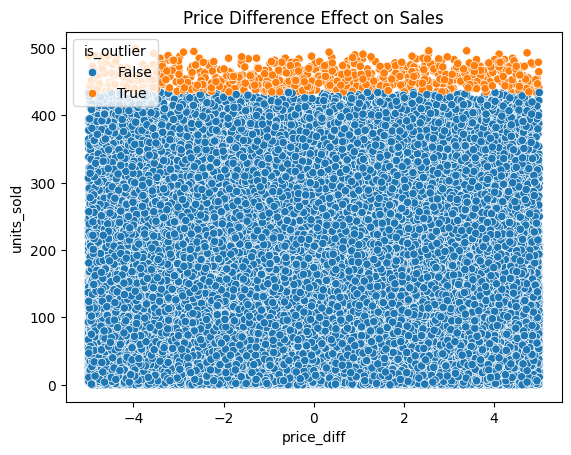

In [ ]:
# check if price difference affect spikes in sales
df['is_outlier'] = df['units_sold'] > threshold_upper
df['price_diff'] = df['competitor_pricing'] - df['price']

sns.scatterplot(data=df, x='price_diff', y='units_sold', hue='is_outlier')
plt.title('Price Difference Effect on Sales')
plt.show()

> Untuk kolom `price_diff`, yang merupakan selisih antara `competitor_pricing` dan `price`, tidak ditemukan korelasi terhadap lonjakan penjualan berdasarkan *scatter plot* yang ditampilkan.

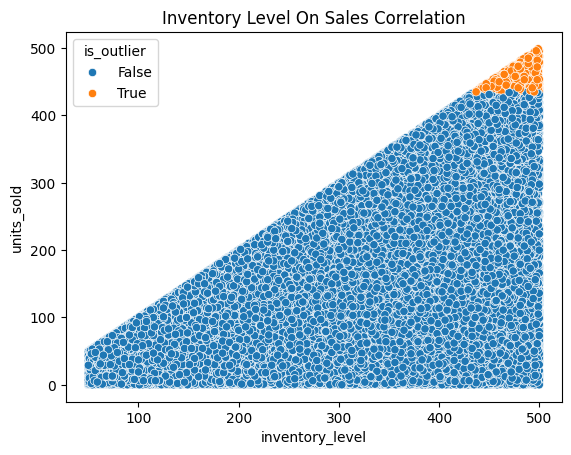

In [ ]:
# check the correlation between inventory level and units sold
sns.scatterplot(data=df, x='inventory_level', y='units_sold', hue='is_outlier')
plt.title('Inventory Level On Sales Correlation')
plt.show()

> Terakhir, diperiksa hubungan antara `inventory_level` dengan `units_sold`. Terlihat pola yang cukup jelas pada *scatter plot*, meskipun tidak terlalu ekstrem. Hal ini mengindikasikan bahwa tingginya penjualan mungkin terjadi karena stok barang memang tersedia dalam jumlah besar, bukan karena adanya promosi khusus.

#### **Handling**

> Pada bagian ini dilakukan penanganan terhadap *outliers*. Berdasarkan analisis sebelumnya, dilakukan metode *capping* agar tidak menghapus data yang dianggap *outliers*.

In [ ]:
# function to cap outliers (capping method)
def cap_outliers(df, num_cols):
  for col in num_cols:
    _, RLB, RUB = outliers_info(df[col])
    # clip outliers
    df[col] = df[col].clip(RLB, RUB)
  return df

# function call
df.drop(columns=['is_outlier', 'price_diff'], inplace=True)
num_cols = df.select_dtypes('number').columns # redefine numerical columns
df_cleaned = cap_outliers(df, num_cols) # apply capping to outliers

> Penanganan *outliers* dilakukan dengan metode *capping*, yaitu mengganti nilai ekstrem dengan nilai batas atas (`RUB`) dan batas bawah (`RLB`) dari fungsi `outliers_info()`. Proses ini dilakukan menggunakan fungsi `cap_outliers()` dan hasilnya disimpan dalam `df_cleaned`.

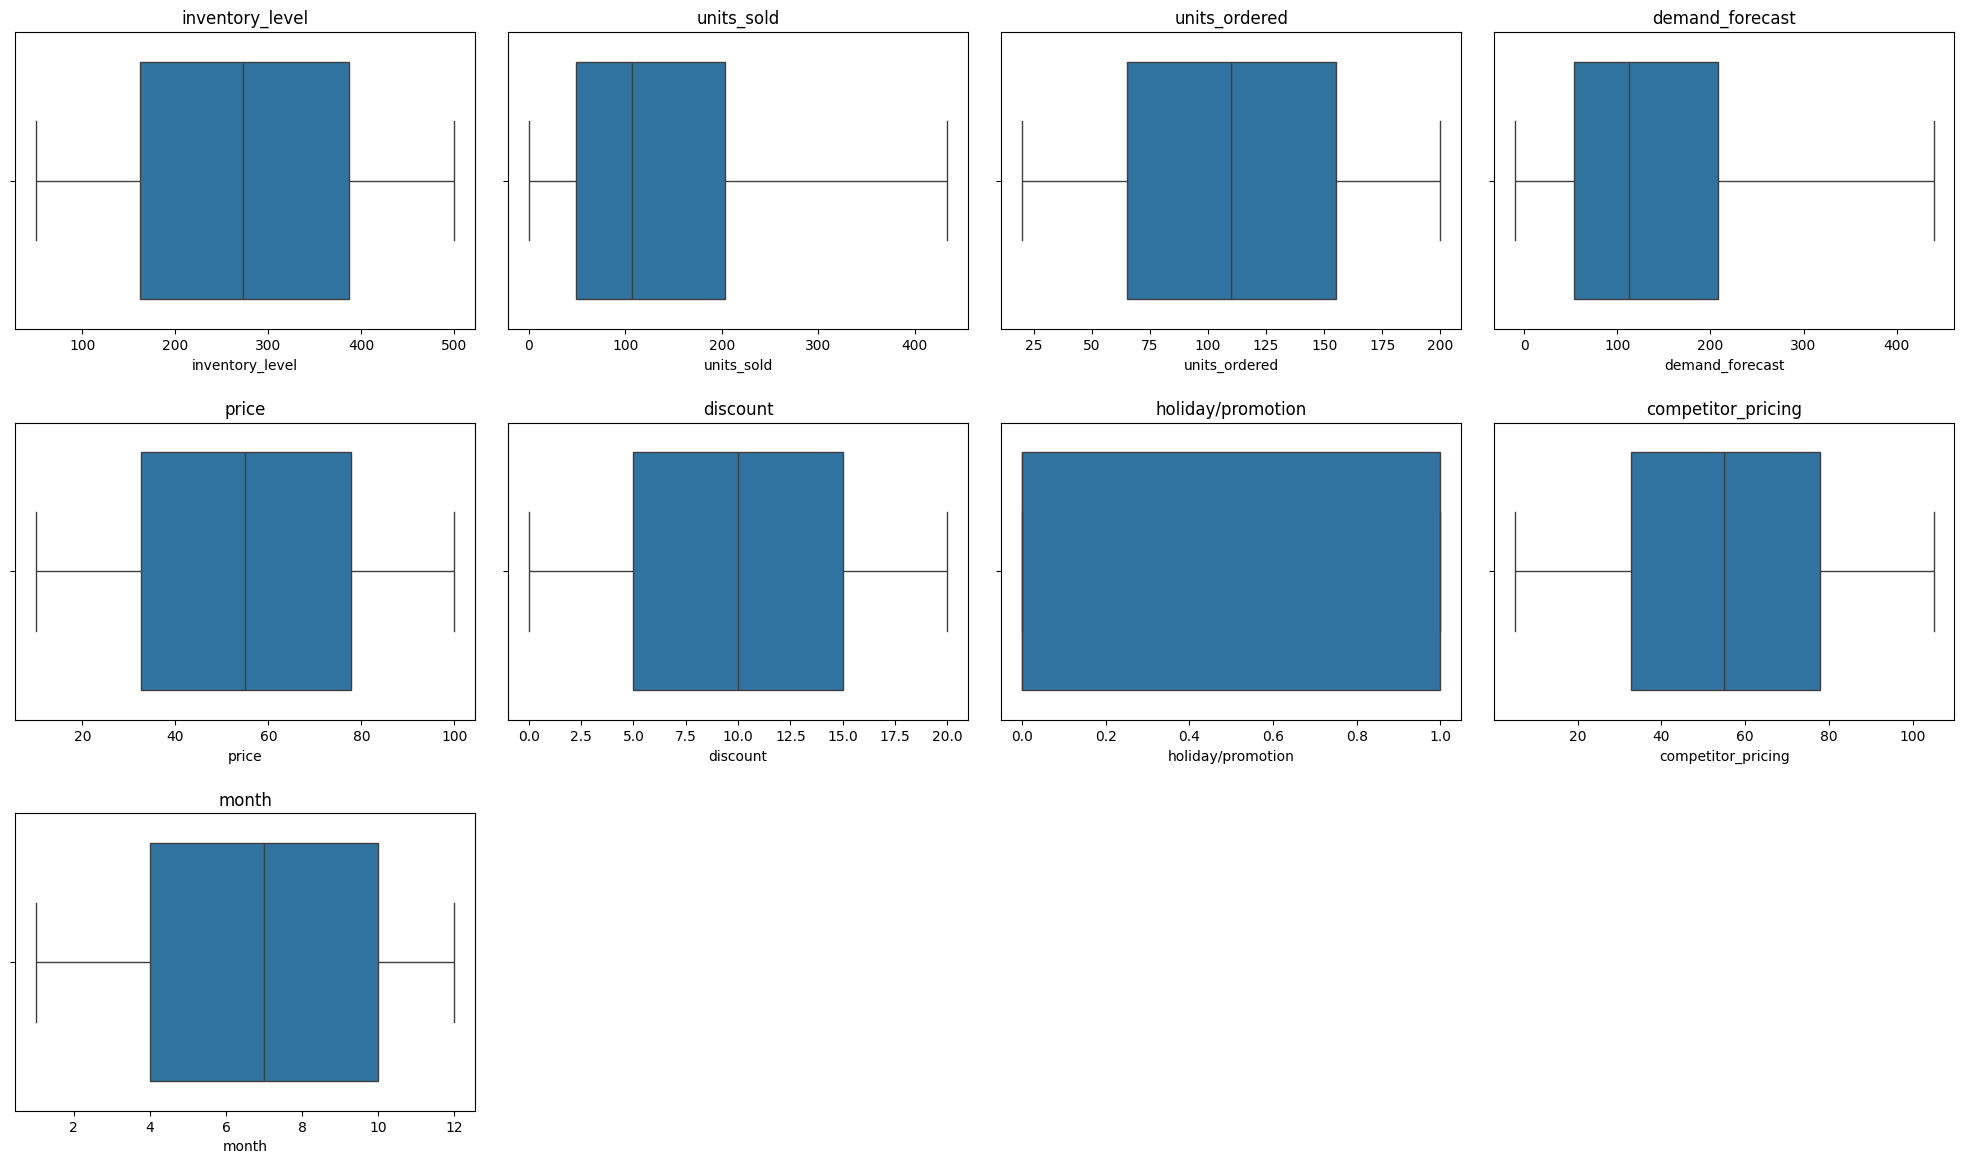



Total column with outliers: 0 out of 9


In [ ]:
# recheck outliers
plot_outliers(df_cleaned, num_cols)
print()
print_outliers(df_cleaned, num_cols)

> Terlihat bahwa setelah dilakukan *capping*, tidak ada lagi kolom yang memiliki *outliers*.

### **Feature Extraction**

> Pada bagian ini dilakukan *feature extraction*, yaitu dengan membuat fitur baru hasil penggabungan atau ekstraksi data dari fitur lain untuk memperluas informasi yang berguna.

In [ ]:
# a column that represents yesterday's sales
df_cleaned['lag_1'] = df_cleaned.groupby(['store_id', 'product_id'])['units_sold'].shift(1)

# a column that represents average sales per week (7 days)
df_cleaned['rolling_mean_7'] = df_cleaned.groupby(['store_id', 'product_id'])['units_sold'].shift(1).rolling(7).mean()

# weekday and weekend columns
df_cleaned['day_of_the_week'] = pd.to_datetime(df_cleaned['date']).dt.dayofweek
df_cleaned['is_weekend'] = df_cleaned['day_of_the_week'].isin([5,6]).astype(int) # 5 for Saturday and 6 for Sunday

# price different column
df_cleaned['price_diff'] = df_cleaned['competitor_pricing'] - df_cleaned['price']

> Fitur-fitur baru yang dihasilkan antara lain:
- `lag_1`: gabungan `store_id` dan `product_id` untuk menghitung penjualan sehari sebelumnya
- `rolling_mean_7`: gabungan `store_id` dan `product_id` untuk menghitung rata-rata penjualan selama 7 hari
- `day_of_the_week`: hasil ekstraksi hari dari kolom `date`
- `is_weekend`: indikator apakah hari tersebut termasuk akhir pekan
- `price_diff`: selisih antara `competitor_pricing` dan `price`

In [ ]:
# check df_cleaned data information
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                73100 non-null  datetime64[ns]
 1   store_id            73100 non-null  object        
 2   product_id          73100 non-null  object        
 3   category            73100 non-null  object        
 4   region              73100 non-null  object        
 5   inventory_level     73100 non-null  int64         
 6   units_sold          73100 non-null  int64         
 7   units_ordered       73100 non-null  int64         
 8   demand_forecast     73100 non-null  float64       
 9   price               73100 non-null  float64       
 10  discount            73100 non-null  int64         
 11  weather_condition   73100 non-null  object        
 12  holiday/promotion   73100 non-null  int64         
 13  competitor_pricing  73100 non-null  float64   

> Setelah *feature extraction*, *dataset* `df_cleaned` memiliki total 21 kolom. Namun, fitur `lag_1` dan `rolling_mean_7` mengandung nilai null yang akan ditangani pada tahap ***preprocessing pipeline***.

### **Data Splitting**

> Pada bagian ini dilakukan pemisahan data menjadi data latih dan data uji berdasarkan urutan tanggal. Hal ini karena proses *forecasting* bersifat *time-series*, yang bergantung pada kronologi data.

In [ ]:
# sort data by date
df_cleaned = df_cleaned.sort_values(by='date').reset_index(drop=True)
df_cleaned

date store_id product_id     category region  inventory_level  \
0     2022-01-01     S001      P0001    Groceries  North              231   
1     2022-01-01     S004      P0013    Furniture   East              191   
2     2022-01-01     S004      P0012  Electronics  North              349   
3     2022-01-01     S004      P0011  Electronics   West              205   
4     2022-01-01     S004      P0010    Groceries   East              447   
...          ...      ...        ...          ...    ...              ...   
73095 2024-01-01     S002      P0008    Furniture  North              218   
73096 2024-01-01     S002      P0007         Toys   West               53   
73097 2024-01-01     S002      P0006         Toys   East              160   
73098 2024-01-01     S002      P0016         Toys  North              258   
73099 2024-01-01     S005      P0020    Groceries   East              117   

       units_sold  units_ordered  demand_forecast  price  ...  \
0             127             55           135.47  33.50  ...   
1              56             65            54.47  61.81  ...   
2               9            165             0.95  14.25  ...   
3              46             27            46.65  54.84  ...   
4             104             96           115.03  33.48  ...   
...           ...            ...              ...    ...  ...   
73095          43            144            51.52  90.38  ...   
73096           2             40            -6.08  63.66  ...   
73097         159             78           151.48  19.06  ...   
73098         110            197           107.61  41.30  ...   
73099           6            165             2.33  78.39  ...   

       weather_condition holiday/promotion  competitor_pricing  seasonality  \
0                  Rainy                 0               29.69       Autumn   
1                  Sunny                 0               63.92       Autumn   
2                  Rainy                 1               18.56       Spring   
3                  Sunny                 1               57.76       Spring   
4                 Cloudy                 0               37.15       Summer   
...                  ...               ...                 ...          ...   
73095              Sunny                 0               94.87       Autumn   
73096              Snowy                 1               62.37       Autumn   
73097              Rainy                 1               15.59       Autumn   
73098             Cloudy                 0               44.96       Autumn   
73099              Rainy                 1               79.52       Spring   

      month  lag_1  rolling_mean_7  day_of_the_week  is_weekend  price_diff  
0         1    NaN             NaN                5           1       -3.81  
1         1    NaN             NaN                5           1        2.11  
2         1    NaN             NaN                5           1        4.31  
3         1    NaN             NaN                5           1        2.92  
4         1    NaN             NaN                5           1        3.67  
...     ...    ...             ...              ...         ...         ...  
73095     1   15.0      130.714286                0           0        4.49  
73096     1   16.0      172.571429                0           0       -1.29  
73097     1  187.0      175.571429                0           0       -3.47  
73098     1   12.0       99.857143                0           0        3.66  
73099     1   40.0       62.714286                0           0        1.13  

[73100 rows x 21 columns]

> Tahapan pertama adalah menyortir data berdasarkan `date` dengan menggunakan sintaks `df_cleaned.sort_values(by='date').reset_index(drop=True)`

In [ ]:
# check the total data for 2024
df_cleaned[df_cleaned['date'] >= '2024-01-01']

date store_id product_id     category region  inventory_level  \
73000 2024-01-01     S004      P0005         Toys   East              217   
73001 2024-01-01     S004      P0013  Electronics   West              113   
73002 2024-01-01     S004      P0012     Clothing   East               85   
73003 2024-01-01     S004      P0011    Groceries   East              155   
73004 2024-01-01     S004      P0010         Toys  North              382   
...          ...      ...        ...          ...    ...              ...   
73095 2024-01-01     S002      P0008    Furniture  North              218   
73096 2024-01-01     S002      P0007         Toys   West               53   
73097 2024-01-01     S002      P0006         Toys   East              160   
73098 2024-01-01     S002      P0016         Toys  North              258   
73099 2024-01-01     S005      P0020    Groceries   East              117   

       units_sold  units_ordered  demand_forecast  price  ...  \
73000         112             88           103.44  77.66  ...   
73001           6             67            10.72  90.89  ...   
73002          63             36            63.69  11.65  ...   
73003         107             47           123.65  88.17  ...   
73004         113             70           121.11  15.35  ...   
...           ...            ...              ...    ...  ...   
73095          43            144            51.52  90.38  ...   
73096           2             40            -6.08  63.66  ...   
73097         159             78           151.48  19.06  ...   
73098         110            197           107.61  41.30  ...   
73099           6            165             2.33  78.39  ...   

       weather_condition holiday/promotion  competitor_pricing  seasonality  \
73000             Cloudy                 1               82.37       Autumn   
73001              Rainy                 0               90.22       Autumn   
73002              Rainy                 0                7.14       Summer   
73003              Snowy                 1               90.26       Autumn   
73004              Snowy                 1               12.13       Autumn   
...                  ...               ...                 ...          ...   
73095              Sunny                 0               94.87       Autumn   
73096              Snowy                 1               62.37       Autumn   
73097              Rainy                 1               15.59       Autumn   
73098             Cloudy                 0               44.96       Autumn   
73099              Rainy                 1               79.52       Spring   

      month  lag_1  rolling_mean_7  day_of_the_week  is_weekend  price_diff  
73000     1  134.0      118.857143                0           0        4.71  
73001     1   37.0       81.285714                0           0       -0.67  
73002     1   77.0       90.428571                0           0       -4.51  
73003     1   30.0       98.571429                0           0        2.09  
73004     1   47.0      120.571429                0           0       -3.22  
...     ...    ...             ...              ...         ...         ...  
73095     1   15.0      130.714286                0           0        4.49  
73096     1   16.0      172.571429                0           0       -1.29  
73097     1  187.0      175.571429                0           0       -3.47  
73098     1   12.0       99.857143                0           0        3.66  
73099     1   40.0       62.714286                0           0        1.13  

[100 rows x 21 columns]

> Setelah diperiksa, data pada tahun 2024 (tanggal `2024-01-01`) hanya terdiri dari 100 baris. Jika pemisahan berdasarkan tahun dilakukan, akan terjadi ketidakseimbangan jumlah data latih dan uji. Oleh karena itu, digunakan metode pemisahan berdasarkan indeks dengan rasio **90:10**.

In [ ]:
# train test split
split_index = int(len(df_cleaned) * 0.9) # 90/10 split
train_df = df_cleaned.iloc[:split_index] # train data consisting of the first date until the split index
test_df = df_cleaned.iloc[split_index:] # test data consisting of the split index row until the latest date

print('Date threshold:', df_cleaned.iloc[split_index]['date'])
print(f'Training set length: {len(train_df)}, starting from {train_df["date"].min()} until {train_df["date"].max()}')
print(f'Testing set length: {len(test_df)}, starting from {test_df["date"].min()} until {test_df["date"].max()}')

# drop date column
train_df.drop(columns='date', inplace=True)
test_df.drop(columns='date', inplace=True)

Date threshold: 2023-10-20 00:00:00
Training set length: 65790, starting from 2022-01-01 00:00:00 until 2023-10-20 00:00:00
Testing set length: 7310, starting from 2023-10-20 00:00:00 until 2024-01-01 00:00:00


<ipython-input-88-94b52b5d30a0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns='date', inplace=True)
<ipython-input-88-94b52b5d30a0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns='date', inplace=True)


> Hasil pemisahan menunjukkan titik pemisah berada pada tanggal `2023-10-20`, menghasilkan **65.790 data latih** dan **7.310 data uji**. Setelah pemisahan, kolom `date` dihapus karena tidak digunakan dalam proses pelatihan model.

### **Preprocessing Pipeline**

> Pada bagian ini, dibuat *preprocessing pipeline* yang mencakup proses *encoding* fitur kategorikal (baik *label encoding* maupun *one-hot encoding*) serta *imputing* nilai null pada fitur `lag_1` dan `rolling_mean_7`. Proses dilakukan secara terpisah pada data latih dan uji untuk menghindari *data leakage*.

In [ ]:
# separate target variable from features
target_col = 'units_sold'

# 1. train data
X_train = train_df.drop(columns=target_col)
y_train = train_df[target_col]

# 2. test data
X_test = test_df.drop(columns=target_col)
y_test = test_df[target_col]

> Langkah pertama adalah memisahkan fitur dengan variabel target (`units_sold`) baik untuk data latih maupun uji.

In [ ]:
# define variables to store columns for different pipeline steps

# 1. id columns for label encoding
id_cols = ['store_id', 'product_id']

# 2. the remaining categorical columns for one-hot encoding
cat_cols = X_train.select_dtypes('object').columns.difference(id_cols).tolist()

# 3. numerical columns for scaling and imputing
num_cols = X_train.select_dtypes('number').columns.difference(id_cols).tolist()

print(f'Label encoding columns: {id_cols}')
print(f'One hot encoding columns: {cat_cols}')
print(f'Numerical columns: {num_cols}')

Label encoding columns: ['store_id', 'product_id']
One hot encoding columns: ['category', 'region', 'seasonality', 'weather_condition']
Numerical columns: ['competitor_pricing', 'day_of_the_week', 'demand_forecast', 'discount', 'holiday/promotion', 'inventory_level', 'is_weekend', 'lag_1', 'month', 'price', 'price_diff', 'rolling_mean_7', 'units_ordered']


> Kolom dipisahkan menjadi tiga jenis untuk tahap *pipeline* yang berbeda:
- *Label encoding*: diterapkan pada kolom ID seperti `store_id` dan `product_id` menggunakan `LabelEncoder()`. Hasilnya disimpan dalam `id_cols`.
- *One-hot encoding*: diterapkan pada kolom kategorikal lainnya (misalnya `region`, `category`, `weather_condition`, dll.) dan disimpan dalam `cat_cols`. Karena jumlah nilai unik kecil (sekitar 4–5), maka tidak menyebabkan peningkatan *dimensionality* yang signifikan.
- Kolom numerik disimpan dalam `num_cols`.

In [ ]:
# label encoding for ids
le_dict = dict()

for col in id_cols:
  encoder = LabelEncoder()
  X_train[col] = encoder.fit_transform(X_train[col]) + 1 # start label from 1
  le_dict[col] = encoder # save encoder for test set

> Tahap *label encoding* menyimpan hasil pengkodean dalam `le_dict` untuk kemudian diaplikasikan pada data uji dengan kolom yang sama.

In [ ]:
# define pipeline transformers

# numeric pipeline
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), # impute nan in lag and rolling columns with 0 indicating no history
    ('scaler', StandardScaler()) # scaling using Standardization technique
])

# categorical pipeline
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# combined pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
], remainder='passthrough')

# final pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])

> Terdapat dua pipeline utama:
- `num_pipeline`: berisi `SimpleImputer` (mengisi null dengan 0 untuk menandakan tidak ada histori) dan `StandardScaler` (melakukan *scaling* guna menyamakan rentang data dengan mengubah rata-rata data menjadi 0 dan simpangan baku menjadi 1).
- `cat_pipeline`: berisi `SimpleImputer` (mengisi dengan modus pada nilai null jika ada) dan `OneHotEncoder` (mengubah kolom kategorikal menjadi numerik dengan memecah setiap nilai unik dalam sebuah kolom baru yang berisi nilai biner).

> Kedua pipeline digabungkan menggunakan `ColumnTransformer` dan disimpan dalam variabel `preprocessor`. `preprocessor` ini akan diterapkan sepenuhnya pada data latih dan uji.

In [ ]:
# apply pipeline on X_train
X_train_prepared = full_pipeline.fit_transform(X_train)
X_train_prepared

array([[-0.97350211,  1.000019  , -0.05279296, ...,  0.        ,
         1.        ,  1.        ],
       [ 0.33311426,  1.000019  , -0.79776666, ...,  1.        ,
         4.        , 13.        ],
       [-1.39835283,  1.000019  , -1.29000114, ...,  0.        ,
         4.        , 12.        ],
       ...,
       [ 0.70643322,  0.5000475 , -0.36742938, ...,  0.        ,
         2.        , 18.        ],
       [-0.7085907 ,  0.5000475 , -0.97085808, ...,  1.        ,
         3.        ,  2.        ],
       [ 1.16449329,  0.5000475 ,  0.59459839, ...,  1.        ,
         2.        , 16.        ]])

In [ ]:
# get feature names out
feature_names = full_pipeline.get_feature_names_out()
print(feature_names)

# remove prefixes from feature names
feature_names = [name.split('__')[-1] for name in feature_names]

print(f'\nTotal features: {len(feature_names)}')

['num__competitor_pricing' 'num__day_of_the_week' 'num__demand_forecast'
 'num__discount' 'num__holiday/promotion' 'num__inventory_level'
 'num__is_weekend' 'num__lag_1' 'num__month' 'num__price'
 'num__price_diff' 'num__rolling_mean_7' 'num__units_ordered'
 'cat__category_Electronics' 'cat__category_Furniture'
 'cat__category_Groceries' 'cat__category_Toys' 'cat__region_North'
 'cat__region_South' 'cat__region_West' 'cat__seasonality_Spring'
 'cat__seasonality_Summer' 'cat__seasonality_Winter'
 'cat__weather_condition_Rainy' 'cat__weather_condition_Snowy'
 'cat__weather_condition_Sunny' 'remainder__store_id'
 'remainder__product_id']

Total features: 28


> Transformasi data latih dilakukan menggunakan `full_pipeline.fit_transform(X_train)` dan hasilnya disimpan dalam `X_train_prepared`. Untuk mengambil nama fitur hasil transformasi, prefix seperti `num__` dan `cat__` dihapus agar nama fitur lebih bersih dan mudah digunakan.

In [ ]:
# create a dataframe for X_train_prepared
X_train_prepared = pd.DataFrame(X_train_prepared, columns=feature_names, index=X_train.index)
X_train_prepared

competitor_pricing  day_of_the_week  demand_forecast  discount  \
0               -0.973502         1.000019        -0.052793  1.409708   
1                0.333114         1.000019        -0.797767 -1.412690   
2               -1.398353         1.000019        -1.290001 -0.707090   
3                0.097977         1.000019        -0.869689 -1.412690   
4               -0.688741         1.000019        -0.240784  0.704109   
...                   ...              ...              ...       ...   
65785            0.619784         0.500047        -0.604809 -0.001491   
65786            1.130139         0.500047         1.905108  1.409708   
65787            0.706433         0.500047        -0.367429  1.409708   
65788           -0.708591         0.500047        -0.970858 -1.412690   
65789            1.164493         0.500047         0.594598  0.704109   

       holiday/promotion  inventory_level  is_weekend     lag_1     month  \
0              -0.996268        -0.335016    1.580971 -1.253621 -1.552787   
1              -0.996268        -0.642877    1.580971 -1.253621 -1.552787   
2               1.003746         0.573172    1.580971 -1.253621 -1.552787   
3               1.003746        -0.535126    1.580971 -1.253621 -1.552787   
4              -0.996268         1.327429    1.580971 -1.253621 -1.552787   
...                  ...              ...         ...       ...       ...   
65785          -0.996268         0.780977   -0.632523  1.660844  1.239174   
65786           1.003746         0.773281   -0.632523 -0.322099  1.239174   
65787           1.003746        -0.858379   -0.632523 -1.106053  1.239174   
65788           1.003746        -1.374045   -0.632523  1.116688  1.239174   
65789          -0.996268         0.196043   -0.632523 -0.976931  1.239174   

          price  ...  region_South  region_West  seasonality_Spring  \
0     -0.832844  ...           0.0          0.0                 0.0   
1      0.254709  ...           0.0          0.0                 0.0   
2     -1.572349  ...           0.0          0.0                 1.0   
3     -0.013049  ...           0.0          1.0                 1.0   
4     -0.833612  ...           0.0          0.0                 0.0   
...         ...  ...           ...          ...                 ...   
65785  0.655771  ...           0.0          1.0                 0.0   
65786  1.160939  ...           0.0          1.0                 1.0   
65787  0.688424  ...           0.0          0.0                 0.0   
65788 -0.874717  ...           0.0          0.0                 0.0   
65789  1.022642  ...           0.0          0.0                 1.0   

       seasonality_Summer  seasonality_Winter  weather_condition_Rainy  \
0                     0.0                 0.0                      1.0   
1                     0.0                 0.0                      0.0   
2                     0.0                 0.0                      1.0   
3                     0.0                 0.0                      0.0   
4                     1.0                 0.0                      0.0   
...                   ...                 ...                      ...   
65785                 0.0                 1.0                      1.0   
65786                 0.0                 0.0                      0.0   
65787                 1.0                 0.0                      0.0   
65788                 0.0                 0.0                      0.0   
65789                 0.0                 0.0                      0.0   

       weather_condition_Snowy  weather_condition_Sunny  store_id  product_id  
0                          0.0                      0.0       1.0         1.0  
1                          0.0                      1.0       4.0        13.0  
2                          0.0                      0.0       4.0        12.0  
3                          0.0                      1.0       4.0        11.0  
4                          0.0                      0.0       4

In [ ]:
# apply transformations to X_test

# 1. label encode store_id and product_id using the saved encoder
for col in id_cols:
  encoder = le_dict[col]
  X_test[col] = encoder.transform(X_test[col]) + 1

# 2. apply full pipeline to X_test
X_test_prepared = full_pipeline.transform(X_test)

# 3. convert processed X_test to dataframe
X_test_prepared = pd.DataFrame(X_test_prepared, columns=feature_names, index=X_test.index)

> Hal serupa dilakukan pada data uji dengan menggunakan `transform()` (bukan `fit_transform()`) agar tidak terjadi *data leakage*. Data latih dan uji yang sudah diproses selanjutnya digunakan untuk tahap pengembangan model.

## **Model Development**

> Bagian ini memaparkan proses pengembangan model. Tiga model yang dipilih untuk dibandingkan kinerjanya adalah **linear regression**, **random forest**, dan **XGBoost** karena keberagaman algoritmanya. Berikut penjelasan masing-masing model, algoritma yang digunakan, serta kelebihan dan kekurangannya:
- **Linear Regression**: model *supervised learning* yang bekerja dengan mencari *best fit line equation* untuk memprediksi nilai target berdasarkan data independen (fitur). Model ini digunakan sebagai *baseline* karena sederhana dan mudah diinterpretasikan. Namun, model ini mengasumsikan hubungan linier antara fitur dan target, yang dalam banyak kasus tidak selalu terpenuhi. Hal ini bisa menyebabkan *underfitting* ketika data bersifat kompleks.
- **Random Forest**: model *supervised learning* yang menggunakan metode *ensemble*, yaitu dengan menggabungkan hasil prediksi dari banyak pohon keputusan (*trees*). Model ini menerapkan algoritma *bagging (bootstrap aggregating)* dengan cara melatih setiap pohon menggunakan *random sampling* dengan pengembalian, yang berarti sampel yang dihasilkan dapat memuat data yang sama sehingga data bersifat saling independen. Karena pendekatan ini, *random forest* mampu memodelkan hubungan kompleks antar fitur dan target serta bersifat *robust* terhadap *missing values*, *outliers*, hingga *scaling*. Model ini juga menyediakan *feature importance* yang membantu memahami kontribusi masing-masing fitur. Namun, model ini sulit diinterpretasikan dibandingkan pohon keputusan tunggal dan mahal secara komputasi jika diterapkan pada *dataset* yang besar.
- **XGBoost**: model *supervised learning* yang juga menggunakan metode *ensemble*, tetapi dengan algoritma *boosting*. Model ini membangun *strong learners* dari *weak learners* secara bertahap, dengan setiap model baru dilatih berdasarkan kesalahan model sebelumnya. Keunggulannya adalah kemampuannya menghindari *overfitting* melalui penggunaan *regularization* seperti *shrinkage* dan *pruning*, efisien dalam memproses *dataset* besar, serta mendukung *parallel processing*. Namun, kekurangannya adalah komputasi yang intensif, interpretasi yang sulit, dan rentan *overfitting* pada *dataset* kecil.

> Referensi:
- [Linear Regression](https://www.geeksforgeeks.org/ml-linear-regression/)
- [Linear Regression Advantages & Disadvantages](https://www.geeksforgeeks.org/ml-advantages-and-disadvantages-of-linear-regression/)
- [Bagging vs Boosting](https://www.geeksforgeeks.org/bagging-vs-boosting-in-machine-learning/)
- [Random Forest](https://aiml.com/what-are-the-advantages-and-disadvantages-of-random-forest/)
- [XGBoost](https://www.geeksforgeeks.org/xgboost/)

### **Model Training**

In [ ]:
# model training: linear regression, random forest, xgboost
lr = LinearRegression().fit(X_train_prepared, y_train)
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_prepared, y_train)
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42).fit(X_train_prepared, y_train)

print('Model training done.')

Model training done.


> Proses pelatihan dilakukan tanpa melakukan penyetelan parameter (*default parameter*), kecuali pada **random forest** dan **XGBoost** di mana nilai `n_estimators` ditentukan terlebih dahulu untuk mencegah pemrosesan yang terlalu lama. Ketiga model ini digunakan sebagai *baseline* untuk melihat performa awal dan menjadi dasar keputusan untuk dilakukan *tuning* lebih lanjut.

### **Model Evaluation**

In [ ]:
# create a dataframe to store model's evaluation result using mean-squared error metric
model_evaluation = pd.DataFrame(columns=['train_mse', 'test_mse', 'train_rmse', 'test_rmse'],
                                index=['Linear Regression', 'Random Forest', 'XGBoost'])

# a dictionary to store each model
model_dict = {
    'Linear Regression': lr,
    'Random Forest': rf,
    'XGBoost': xgb
}

> Untuk mengevaluasi performa model, digunakan dua metrik, yaitu *mean squared error* (MSE) dan *root mean squared error* (RMSE):
- **Mean Squared Error (MSE)**: Mengukur rata-rata selisih antara nilai aktual dan prediksi yang dikuadratkan. Metrik ini merepresentasikan *variance* dari residual. Semakin kecil nilai MSE, semakin baik model dalam memprediksi.
- **Root Mean Squared Error (RMSE)**: Merupakan akar kuadrat dari MSE dan mengukur simpangan baku dari residual. RMSE sering digunakan karena unitnya sama dengan variabel target (`units_sold`) sehingga lebih mudah diinterpretasikan.


> Referensi: [Regression Metrics](https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e)

> Untuk mempermudah pembacaan hasil evaluasi, dibuat *dataframe* `model_evaluation` yang menyimpan nilai MSE dan RMSE pada data latih dan data uji. Hal ini juga membantu mengidentifikasi apakah suatu model mengalami *overfitting* sehingga bisa diputuskan tindakan lanjutan.

In [ ]:
# model prediction and evaluation
def evaluate_model(model_df, model_dict):
  for name, model in model_dict.items():
    # predict
    y_train_pred = model.predict(X_train_prepared)
    y_test_pred = model.predict(X_test_prepared)

    # MSE
    model_df.loc[name, 'train_mse'] = round(mean_squared_error(y_true=y_train, y_pred=y_train_pred), 3)
    model_df.loc[name, 'test_mse'] = round(mean_squared_error(y_true=y_test, y_pred=y_test_pred), 3)

    # RMSE
    model_df.loc[name, 'train_rmse'] = round(root_mean_squared_error(y_true=y_train, y_pred=y_train_pred), 3)
    model_df.loc[name, 'test_rmse'] = round(root_mean_squared_error(y_true=y_test, y_pred=y_test_pred), 3)

# display result
evaluate_model(model_evaluation, model_dict)
model_evaluation

train_mse test_mse train_rmse test_rmse
Linear Regression    73.493    74.62      8.573     8.638
Random Forest        10.037   72.845      3.168     8.535
XGBoost              55.576   73.891      7.455     8.596

In [ ]:
# check target variable's descriptive statistics to help in interpreting result
print('Target summary stats:')
df_cleaned['units_sold'].describe()

Target summary stats:


count    73100.000000
mean       136.241984
std        108.274638
min          0.000000
25%         49.000000
50%        107.000000
75%        203.000000
max        434.000000
Name: units_sold, dtype: float64

> Berdasarkan nilai **root mean squared error (RMSE)** dari ketiga model yang berada di kisaran **9 unit**, berikut adalah interpretasi performa model terhadap skala data target `units_sold`:
- **Rata-rata penjualan harian** adalah sekitar **136 unit**. Hal ini berarti kesalahan prediksi model hanya sekitar **6-7%** (9/136 * 100 = ~6.6), yang relatif rendah dibandingkan besarnya rata-rata penjualan.
- **Simpangan baku** (*standard deviation*) dari penjualan harian adalah sekitar **108 unit**, yang mengindikasikan adanya fluktuasi alami yang cukup besar dalam data. Dengan RMSE hanya sekitar 9 unit, model tidak menyimpang terlalu jauh dari pola alami data dan menunjukkan bahwa **model cukup baik dalam menangkap pola dasar penjualan**.

> Namun, terdapat beberapa catatan penting:
- **Linear regression** menunjukkan error terbesar, mengindikasikan potensi *underfitting*.
- **Random forest** memiliki `train_mse` paling kecil, tetapi perbedaan dengan `test_mse`-nya sangat besar. Hal ini mengindikasikan *overfitting* dan perlu dilakukan *hyperparameter tuning*.
- **XGBoost** memiliki error terbesar kedua, tetapi selisih antara `train_mse` dan `test_mse` tidak sebesar random forest, lebih baik karena menunjukkan kemungkinan *overfitting* yang rendah. Walaupun begitu, tetap perlu dilakukan *tuning* untuk meningkatkan performa.

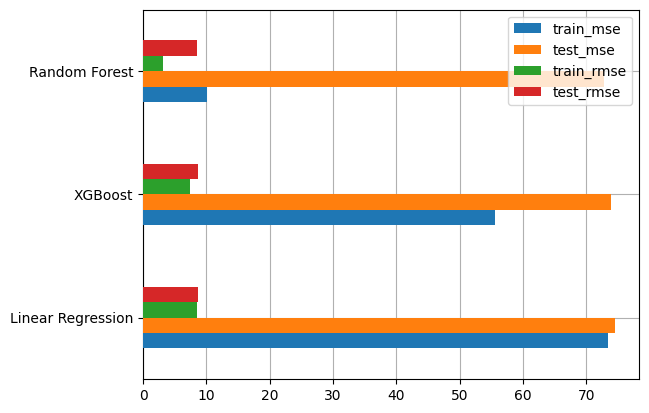

In [ ]:
# plot evaluation results
fig, ax = plt.subplots()

model_evaluation.sort_values(by='test_mse', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

> Visualisasi hasil evaluasi juga menunjukkan bahwa **linear regression** memiliki nilai error terbesar. Sementara itu, **random forest** meskipun memiliki nilai MSE kecil pada data uji, menunjukkan gejala *overfitting* yang terlihat sangat jelas.

### **Hyperparameter Tuning**

> Bagian ini memaparkan proses *hyperparameter tuning* menggunakan `RandomizedSearchCV`. Pendekatan ini dilakukan dengan cara melakukan *sampling* secara acak dari distribusi parameter yang telah ditentukan sebelumnya. Metode ini dipilih karena lebih efisien secara komputasi dibandingkan `GridSearchCV`, terutama untuk *dataset* berukuran besar.

In [ ]:
# hyperparameter tuning on random forest using RandomizedSearchCV

# define param grid
rf_params = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5]
}

# initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_params,
    n_iter=3,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=4,
    random_state=42
)
rf_random.fit(X_train_prepared, y_train)

# save best model
print(f'Random Search RF Best Params: {rf_random.best_params_}')
best_rf_random = rf_random.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Random Search RF Best Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}


> Parameter yang ditentukan untuk *tuning*:
- `n_estimators`: jumlah pohon keputusan dalam hutan. Semakin banyak jumlahnya, semakin baik performa model, tetapi semakin tinggi juga biaya komputasinya.
- `min_samples_split`: jumlah minimum sampel yang dibutuhkan untuk memisahkan suatu node.
- `min_samples_leaf`: jumlah minimum sampel yang harus ada di setiap daun (*leaf node*).
- `max_depth`: kedalaman maksimum dari masing-masing pohon keputusan. Dengan membatasi nilai ini, model berkemungkinan terhindar dari *overfitting*.

> Hasil *tuning* menunjukkan parameter terbaik untuk **random forest** adalah:
```
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}
```
Selanjutnya, dilakukan evaluasi ulang untuk melihat apakah hasil *tuning* menghasilkan kinerja yang lebih baik dibandingkan model awal.

In [ ]:
# hyperparameter tuning on XGBoost using RandomizedSearchCV

xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# initialize RandomizedSearchCV
xgb_random = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=xgb_params,
    n_iter=5,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)
xgb_random.fit(X_train_prepared, y_train)

# save best model
print(f'Random Search XGB Best Params: {xgb_random.best_params_}')
best_xgb_random = xgb_random.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Random Search XGB Best Params: {'subsample': 1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1}


> Parameter yang ditentukan untuk *tuning*:
- `n_estimators`: jumlah pohon yang digunakan dalam *boosting*.
- `max_depth`: kedalaman maksimum tiap pohon untuk mengontrol kompleksitas.
- `learning_rate`: mengontrol kontribusi setiap pohon baru; nilai yang lebih kecil membuat model belajar lebih lambat tetapi stabil.
- `subsample`: proporsi sampel data yang digunakan pada tiap iterasi.
- `colsample_bytree`: proporsi fitur yang dipakai pada setiap pohon.

> Hasil *tuning* menunjukkan parameter terbaik untuk **XGBoost** adalah:
```
{'subsample': 1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1}
```
Sama seperti sebelumnya, dilakukan evaluasi ulang untuk melihat perbaikan performa.

In [ ]:
# add the tuning results to model_dict for evaluation
model_dict['Best Random Forest'] = best_rf_random
model_dict['Best XGBoost'] = best_xgb_random

# evaluate model
evaluate_model(model_evaluation, model_dict)

# display result
model_evaluation

train_mse test_mse train_rmse test_rmse
Linear Regression     73.493    74.62      8.573     8.638
Random Forest         10.037   72.845      3.168     8.535
XGBoost               55.576   73.891      7.455     8.596
Best Random Forest    60.517   70.571      7.779     8.401
Best XGBoost           61.61   71.792      7.849     8.473

> Hasil evaluasi menunjukkan bahwa *tuning* pada **random forest** dan **XGBoost** menghasilkan kinerja yang lebih baik dari model awal. Terlihat bahwa hasil *tuning* **random forest** sudah tidak terlalu *overfitting* dan memiliki nilai MSE yang lebih kecil. Hal serupa terjadi pada **XGBoost**. Keduanya memiliki selisih error yang cukup kecil, dengan model **random forest** terlihat sedikit lebih unggul.

> Dengan demikian, model yang dibandingkan pada tahap akhir adalah:
- **Linear Regression**
- **Best Random Forest**
- **Best XGBoost**

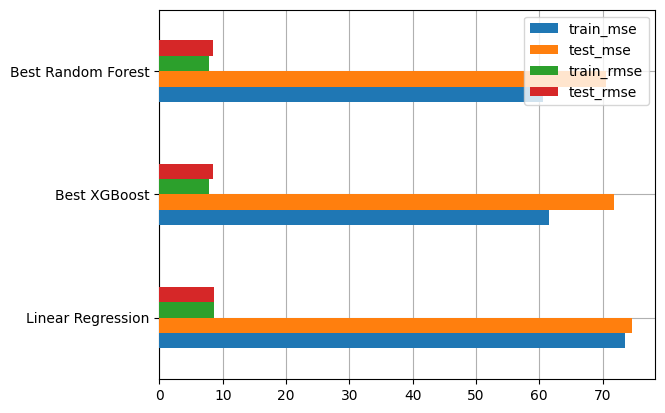

In [ ]:
# plot evaluation results after tuning
fig, ax = plt.subplots()

model_evaluation.sort_values(by='test_mse', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

In [ ]:
# listing all the selected final models
final_models = ['Linear Regression', 'Best Random Forest', 'Best XGBoost']

# filter dataframe to only include the final models
model_evaluation = model_evaluation.loc[final_models]
model_evaluation

train_mse test_mse train_rmse test_rmse
Linear Regression     73.493    74.62      8.573     8.638
Best Random Forest    60.517   70.571      7.779     8.401
Best XGBoost           61.61   71.792      7.849     8.473

In [ ]:
# remove previous models from model_dict
models_to_remove = ['Random Forest', 'XGBoost']

model_dict = {k: v for k, v in model_dict.items() if k not in models_to_remove}
model_dict.keys()

dict_keys(['Linear Regression', 'Best Random Forest', 'Best XGBoost'])

### **Model Testing**

In [ ]:
# model testing
testing_data = X_test_prepared.copy() # get all data from testing set
pred_dict = {'y_true': y_test.copy()} # get the true value of the testing data

# predict
for name, model in model_dict.items():
  pred_dict['prediction_' + name] = model.predict(testing_data).astype(float).round(1)
  pred_dict['error_' + name] = (pred_dict['prediction_' + name] - pred_dict['y_true']).abs()

# convert result to dataframe
df_preds = pd.DataFrame(pred_dict)
df_preds.tail(5)

y_true  prediction_Linear Regression  error_Linear Regression  \
73095      43                          47.1                      4.1   
73096       2                         -10.7                     12.7   
73097     159                         145.8                     13.2   
73098     110                         102.7                      7.3   
73099       6                          -1.9                      7.9   

       prediction_Best Random Forest  error_Best Random Forest  \
73095                           44.7                       1.7   
73096                            1.9                       0.1   
73097                          146.8                      12.2   
73098                          102.7                       7.3   
73099                            6.7                       0.7   

       prediction_Best XGBoost  error_Best XGBoost  
73095                     46.2                 3.2  
73096                      2.6                 0.6  
73097                    145.1                13.9  
73098                    103.4                 6.6  
73099                      7.0                 1.0

> Proses prediksi dilakukan pada seluruh data uji, bukan hanya sebagian kecil, untuk memastikan model dipilih berdasarkan kinerja yang konsisten dan menyeluruh. Untuk membantu interpretasi, ditambahkan kolom *error* yang menghitung selisih antara nilai prediksi dan nilai aktual. Selain itu, ditampilkan 5 data terakhir untuk memberikan gambaran konkret terhadap hasil prediksi masing-masing model.

> Hasilnya, **Best XGBoost** dan **Best Random Forest** secara konsisten memberikan prediksi terbaik di sebagian besar data dengan *total error* yang rendah. Sementara itu, **Linear Regression** cenderung mengalami fluktuasi error yang lebih besar.

In [ ]:
# check the average absolute error based on the predictions
lr_error_avg = df_preds['error_Linear Regression'].mean().round(3)
rf_error_avg = df_preds['error_Best Random Forest'].mean().round(3)
xgb_error_avg = df_preds['error_Best XGBoost'].mean().round(3)

print(f'Linear Regression Error Average: {lr_error_avg}')
print(f'Random Forest Error Average: {rf_error_avg}')
print(f'XGBoost Error Average: {xgb_error_avg}')

Linear Regression Error Average: 7.442
Random Forest Error Average: 7.162
XGBoost Error Average: 7.211


> Untuk memperjelas hasil tersebut, dihitung juga rata-rata absolut error (**MAE**) dari masing-masing model berdasarkan data uji secara keseluruhan. Hal ini dilakukan untuk melihat seberapa jauh masing-masing model "meleset" secara rata-rata dari nilai aktual.

> Berdasarkan evaluasi terhadap sampel data uji, error berkisar antara **7-8 unit** secara rata-rata. Seluruh nilai ini masih berada dalam rentang error yang wajar jika dibandingkan dengan skala penjualan harian. Tidak pula ditemukan indikasi error yang ekstrem, meskipun terlihat bahwa model **linear regression** memiliki error yang cenderung lebih tinggi dibandingkan dua model lainnya.

In [ ]:
# create a new dataframe containing data test for evaluation per store
y_pred_rf = best_rf_random.predict(X_test_prepared) # get prediction using best model: rf after tuning

# combine testing data and prediction for evaluation
store_eval = X_test_prepared.copy()
store_eval['y_true'] = y_test
store_eval['y_pred_rf'] = y_pred_rf

# display dataframe
store_eval

competitor_pricing  day_of_the_week  demand_forecast  discount  \
65790            0.611767         0.500047         0.011771 -0.001491   
65791           -1.176957         0.500047         0.344802 -0.001491   
65792           -1.320864         0.500047        -0.380581 -0.001491   
65793           -1.085345         0.500047        -0.355565 -1.412690   
65794            1.105709         0.500047        -0.850375 -0.001491   
...                   ...              ...              ...       ...   
73095            1.514528        -1.499839        -0.824898 -0.001491   
73096            0.273948        -1.499839        -1.354658  1.409708   
73097           -1.511723        -1.499839         0.094454  1.409708   
73098           -0.390621        -1.499839        -0.309027 -0.707090   
73099            0.928592        -1.499839        -1.277309  1.409708   

       holiday/promotion  inventory_level  is_weekend     lag_1     month  \
65790          -0.996268        -0.973827   -0.632523  0.646315  1.239174   
65791           1.003746         0.396152   -0.632523  0.065267  1.239174   
65792          -0.996268        -0.950737   -0.632523 -0.626457  1.239174   
65793           1.003746        -1.397134   -0.632523  1.623952  1.239174   
65794          -0.996268        -1.389438   -0.632523  0.268173  1.239174   
...                  ...              ...         ...       ...       ...   
73095          -0.996268        -0.435071   -0.632523 -1.115276 -1.552787   
73096           1.003746        -1.704995   -0.632523 -1.106053 -1.552787   
73097           1.003746        -0.881468   -0.632523  0.471078 -1.552787   
73098          -0.996268        -0.127211   -0.632523 -1.142945 -1.552787   
73099           1.003746        -1.212418   -0.632523 -0.884701 -1.552787   

          price  ...  seasonality_Spring  seasonality_Summer  \
65790  0.678436  ...                 1.0                 0.0   
65791 -1.129414  ...                 0.0                 0.0   
65792 -1.203941  ...                 0.0                 1.0   
65793 -1.047204  ...                 0.0                 1.0   
65794  0.932365  ...                 0.0                 1.0   
...         ...  ...                 ...                 ...   
73095  1.352250  ...                 0.0                 0.0   
73096  0.325778  ...                 0.0                 0.0   
73097 -1.387569  ...                 0.0                 0.0   
73098 -0.533200  ...                 0.0                 0.0   
73099  0.891644  ...                 1.0                 0.0   

       seasonality_Winter  weather_condition_Rainy  weather_condition_Snowy  \
65790                 0.0                      0.0                      0.0   
65791                 0.0                      0.0                      0.0   
65792                 0.0                      0.0                      0.0   
65793                 0.0                      1.0                      0.0   
65794                 0.0                      0.0                      0.0   
...                   ...                      ...                      ...   
73095                 0.0                      0.0                      0.0   
73096                 0.0                      0.0                      1.0   
73097                 0.0                      1.0                      0.0   
73098                 0.0                      0.0                      0.0   
73099                 0.0                      1.0                      0.0   

       weather_condition_Sunny  store_id  product_id  y_true   y_pred_rf  
65790                      0.0       2.0        15.0     131  137.079402  
65791                      1.0       2.0        14.0     178  171.384791  
65792                      0.0       2.0        13.0      90   94.865083  
65793                      0.0       2.0        12.0      84   87.482632  
65794                      1.0       2.0        11.0      40   43.967781  
...                        ...       

> Setelah melakukan evaluasi model secara keseluruhan, dilakukan pula evaluasi tambahan dengan memisahkan evaluasi berdasarkan toko (`store_id`). Hal ini dilakukan untuk mengukur kinerja model secara **lebih granular** sekaligus mengetahui apakah model bekerja secara konsisten di semua toko atau ada toko-toko tertentu yang lebih sulit diprediksi.

In [ ]:
# additional testing: evaluation per store

store_errors = []

# evaluate based on store_id
for store in store_eval['store_id'].unique():
  store_data = store_eval[store_eval['store_id'] == store]

  y_true = store_data['y_true']
  y_pred = store_data['y_pred_rf']

  # metrics evaluation
  mse = mean_squared_error(y_true, y_pred)
  rmse = root_mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)

  # append all data to list
  store_errors.append({
      'store_id': store,
      'MSE': mse,
      'RMSE': rmse,
      'MAE': mae
  })

# create a dataframe based on each store's evaluation sorted by the smallest error
store_errors_df = pd.DataFrame(store_errors).sort_values(by='RMSE')
store_errors_df

store_id        MSE      RMSE       MAE
3       5.0  69.909183  8.361171  7.068888
1       4.0  70.013739  8.367421  7.159817
0       2.0  70.644238  8.405013  7.168164
2       3.0  71.061937  8.429824  7.198550
4       1.0  71.224515  8.439462  7.216540

> Berikut adalah temuan dari evaluasi model terhadap data uji yang dibagi berdasarkan `store_id`.
- Model terbaik (**Random Forest**) memberikan hasil prediksi yang relatif konsisten di semua store, dengan nilai RMSE yang saling berdekatan (sekitar 8.36-8.44).
- Store 5 memiliki akurasi terbaik (nilai error terkecil pada semua metrik), sedangkan store 1 memiliki akurasi terendah meskipun perbedaannya tidak signifikan.

> Temuan ini menunjukkan bahwa **model dapat melakukan generalisasi data dengan cukup baik di seluruh toko**, tanpa adanya bias yang signifikan terhadap toko tertentu.

### **Final Conclusion**

> Berikut adalah kesimpulan akhir dari evaluasi dan pengujian model pada data uji:
- **Best Random Forest** menjadi model dengan kinerja terbaik secara keseluruhan, dihitung dari metrik MSE, RMSE, hingga MAE terendah pada keseluruhan data uji (7.162).
- **Best XGBoost** juga menunjukkan performa yang sangat dekat dengan Random Forest, dengan MAE hanya sedikit lebih tinggi (7.211), dan mampu memberikan prediksi yang akurat pada data dengan nilai penjualan rendah.
- **Linear Regression** memiliki error tertinggi (dengan MAE sebesar 7.442 pada data uji) dan menunjukkan kelemahan dalam memprediksi data dengan nilai ekstrem, seperti terlihat pada error besar (12.7 unit) pada salah satu data uji.

> Dengan mempertimbangkan akurasi dan konsistensi, **Best Random Forest** dipilih sebagai model terbaik untuk memprediksi permintaan penjualan produk pada kasus ini.